In [133]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import requests
import parmap
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from scipy import stats
import math
from Bio import AlignIO
from biodl.umols import Umols
from rdkit.Chem import rdmolops, Descriptors
import pickle as cPickle
import warnings
warnings.filterwarnings('ignore')
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# BindingDB
https://www.bindingdb.org/rwd/bind/index.jsp

In [134]:
# # https://www.bindingdb.org/bind/chemsearch/marvin/SDFdownload.jsp?download_file=/bind/downloads/BindingDB_All_2022m5.tsv.zip
# !wget https://www.bindingdb.org/bind/downloads/BindingDB_All_2022m6.tsv.zip
# !unzip BindingDB_All_2022m6.tsv.zip

# with open('./BindingDB_All.tsv') as f:
#     lines = f.readlines()
# cols = lines[0].split('\t')[:24]
# data1 = []
# for line in lines[1:]:
#     data1.append(line.split('http://www.bindingdb.org/')[0].split('\t'))
# data2 = []
# for line in lines[1:]:
#     dlist = []
#     da = line.split('submit=Search')[-1].split('\t')[-9:]
#     dat = [d.split(',') for d in da]
#     for da in dat:
#         if len(da[0]) > 0:
#             for d in da:
#                 if len(d) == 6:
#                     dlist.append(d)
                    
#     if len(dlist) > 0: 
#         data2.append(','.join(dlist))
#     else:
#         data2.append('NaN')
# bdb = pd.DataFrame(data1, columns=cols)
# bdb['Entry'] = [d.split(',')[0] for d in data2]
# bdb = bdb[bdb['Entry'] != 'NaN'].reset_index(drop=True)
# bindingdb = bdb[['Entry', 'Ligand SMILES', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)']]
# bindingdb.columns = ['Entry', 'SMILES', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)']
# bindingdb = bindingdb.dropna(subset=['Entry', 'SMILES', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)']).reset_index(drop=True)
# bindingdb

In [135]:
# bindingdb.to_csv('./BindingDB/BindingDB_All.csv', index=False)

In [136]:
bindingdb = pd.read_csv('./BindingDB/BindingDB_All.csv')
bindingdb

Entry                                             SMILES Ki (nM)  \
0        P08684  Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...     NaN   
1        P51570  O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...     NaN   
2        P42574  CN(Cc1ccc(s1)C(=O)N[C@@H](CC(O)=O)C(=O)CSCc1cc...      90   
3        P29466  OC(=O)C[C@H](NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...     160   
4        P29466  OC(=O)C[C@H](NC(=O)c1ccc(CNS(=O)(=O)c2ccc(O)c(...    3900   
...         ...                                                ...     ...   
2248535  P11712  COc1cc(ccc1-n1cnc(C)c1)C1=CC2=NOC[C@@H](N2CCC1...     NaN   
2248536  P10635  COc1cc(\C=C2/CCCN3[C@@H](C)[C@H](ON=C23)c2cc(F...     NaN   
2248537  P10635  COc1cc(\C=C2/CCCN3[C@@H](C)[C@H](ON=C23)c2cc(F...     NaN   
2248538  P10635  COc1cc(ccc1-n1cnc(C)c1)C1=CC2=NO[C@@H](CN2CCC1...     NaN   
2248539  P10635  COc1cc(ccc1-n1cnc(C)c1)C1=CC2=NOC[C@@H](N2CCC1...     NaN   

        IC50 (nM) Kd (nM)  
0          >50000     NaN  
1          6676.9     NaN  
2             NaN     NaN  
3             NaN     NaN  
4             NaN     NaN  
...           ...     ...  
2248535      8000     NaN  
2248536     49000     NaN  
2248537     49000     NaN  
2248538     48000     NaN  
2248539      8000     NaN  

[2248540 rows x 5 columns]

In [137]:
TAG = "umols"
fn_l_midsmi = "./BindingDB/BindingDB_All.csv"
um = Umols(TAG)
um.Read_l_midsmi(fn_l_midsmi, col_mid='SMILES', col_smi='SMILES', sep=',')
um.Clean()
um.Dump(TAG)

fp = open("%s/umols.pickle" % TAG, 'rb')
tag = cPickle.load(fp)
bool_chkin = cPickle.load(fp)
bool_clean = cPickle.load(fp)
l_midsmi = cPickle.load(fp)
l_cln_midcsmi = cPickle.load(fp)
l_cln_mids = cPickle.load(fp)
l_cln_csmi = cPickle.load(fp)
l_uniq_csmi = cPickle.load(fp)
l_skip_mids = cPickle.load(fp)
d_cln_mid2csmi = cPickle.load(fp)
d_cln_csmi2mids = cPickle.load(fp)
fp.close()

def getsmi(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        mols = rdmolops.GetMolFrags(m, asMols=True)
        m0 = max(mols, key=lambda m: m.GetNumAtoms())
        csmi = Chem.MolToSmiles(m0, isomericSmiles=True, canonical=True)
        if csmi in l_uniq_csmi:
            return Chem.MolToSmiles(Chem.MolFromSmiles(csmi))
        else:
            return 0
    except:
        return 0

smi = parmap.map(getsmi, bindingdb['SMILES'].tolist(), pm_pbar=True, pm_processes=100)

bindingdb['SMILES'] = smi
bindingdb = bindingdb[bindingdb['SMILES'] != 0].reset_index(drop=True)
bindingdb

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>token is not OK!!, csmi= Cn1c([Se][Se]c2c(C(=O)OC(C)(C)C)c3ccccc3n2C)c(C(=O)OC(C)(C)C)c2ccccc21
#Umols>Err in Clean>token is not OK!!, csmi= Cn1c([Se][Se]c2c(C(=O)O)c3ccccc3n2C)c(C(=O)O)c2ccccc21
#Umols>Err in Clean>token is not OK!!, csmi= CNC(=O)c1c([Se][Se]c2c(C(=O)NC)c3ccccc3n2C)n(C)c2ccccc12
#Umols>Err in Clean>token is not OK!!, csmi= CCN(CC)CCNC(=O)c1c([Se][Se]c2c(C(=O)NCCN(CC)CC)c3ccccc3n2C)n(C)c2ccccc12
#Umols>Err in Clean>token is not OK!!, csmi= CNC(=O)c1c([Se][Se]c2[nH]c3ccccc3c2C(=O)NC)[nH]c2ccccc12
#Umols>Err in Clean>token is not OK!!, csmi= CCN(CC)CC

#Umols>Err in Clean>out-of-mwRange!!, mw=174.2
#Umols>Err in Clean>out-of-mwRange!!, mw=178.2
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>out-of-mwRange!!, mw=182.2
#Umols>Err in Clean>out-of-mwRange!!, mw=177.3
#Umols>Err in Clean>out-of-mwRange!!, mw=176.3
#Umols>Err in Clean>out-of-mwRange!!, mw=184.3
#Umols>Err in Clean>out-of-mwRange!!, mw=193.2
#Umols>Err in Clean>out-of-mwRange!!, mw=174.2
#Umols>Err in Clean>out-of-mwRange!!, mw=160.2
#Umols>Err in Clean>out-of-mwRange!!, mw=159.2
#Umols>Err in Clean>out-of-mwRange!!, mw=190.2
#Umols>Err in Clean>out-of-mwRange!!, mw=160.2
#Umols>Err in Clean>out-of-mwRange!!, mw=175.2
#Umols>Err in Clean>out-of-mwRange!!, mw=160.2
#Umols>Err in Clean>out-of-mwRange!!, mw=175.2
#Umols>Err in Clean>out-of-mwRange!!, mw=160.2
#Umols>Err in Clean>out-of-mwRange!!, mw=190.2
#Umols>Err in Clean>out-of-mwRange!!, mw=190.2
#Umols>Err in Clean>token is not OK!!, csmi= O=C(NCc1ccc

#Umols>Err in Clean>out-of-mwRange!!, mw=193.2
#Umols>Err in Clean>out-of-mwRange!!, mw=180.2
#Umols>Err in Clean>out-of-mwRange!!, mw=190.2
#Umols>Err in Clean>out-of-mwRange!!, mw=852.9
#Umols>Err in Clean>out-of-mwRange!!, mw=174.2
#Umols>Err in Clean>token is not OK!!, csmi= O=c1c2ccccc2[se]n1-c1ccccc1
#Umols>Err in Clean>out-of-mwRange!!, mw=188.2
#Umols>Err in Clean>out-of-mwRange!!, mw=188.2
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 120
#Umols>Err in Clean>out-of-mwRange!!, mw=937.2
#Umols>Err in Clean>out-of-mwRange!!, mw=935.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1000.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1035.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1131.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1000.3
#Umols>Err in Clean>out-of-mwRange!!, mw=974.2
#Umols>Err in Clean>out-of-mwRange!!, mw=965.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1058.3
#Umols>Err in Clean>out-of-mwRange!!, mw=985.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1073.3
#Umols>Err in Clean>out-

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 121
#Umols>Err in Clean>out-of-mwRange!!, mw=196.2
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 121
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 173
#Umols>Err in Clean>out-of-mwRange!!, mw=178.2
#Umols>Err in Clean>out-of-mwRange!!, mw=151.2
#Umols>Err in Clean>out-of-mwRange!!, mw=181.2
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 123
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 107
#Umols>Err in Clean>out-of-mwRange!!, mw=185.2
#Umols>Err in Clean>out-of-mwRange!!, mw=192.1
#Umols>Err in Clean>out-of-mwRange!!, mw=189.3
#Umols>Err in Clean>out-of-mwRange!!, mw=805.9
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err i

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>out-of-mwRange!!, mw=1067.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1058.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1017.2
#Umols>Err in Clean>out-of-mwRange!!, mw=989.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1002.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1039.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1030.2
#Umols>Err in Clean>out-of-mwRange!!, mw=973.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1001.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1077.3
#Umols>Err i

#Umols>Err in Clean>out-of-mwRange!!, mw=809.4
#Umols>Err in Clean>out-of-mwRange!!, mw=806.4
#Umols>Err in Clean>out-of-mwRange!!, mw=811.4
#Umols>Err in Clean>out-of-mwRange!!, mw=895.5
#Umols>Err in Clean>out-of-mwRange!!, mw=909.6
#Umols>Err in Clean>out-of-mwRange!!, mw=880.5
#Umols>Err in Clean>out-of-mwRange!!, mw=866.5
#Umols>Err in Clean>out-of-mwRange!!, mw=909.6
#Umols>Err in Clean>out-of-mwRange!!, mw=855.5
#Umols>Err in Clean>out-of-mwRange!!, mw=895.5
#Umols>Err in Clean>out-of-mwRange!!, mw=880.5
#Umols>Err in Clean>out-of-mwRange!!, mw=866.5
#Umols>Err in Clean>out-of-mwRange!!, mw=880.5
#Umols>Err in Clean>out-of-mwRange!!, mw=880.5
#Umols>Err in Clean>out-of-mwRange!!, mw=852.5
#Umols>Err in Clean>out-of-mwRange!!, mw=934.5
#Umols>Err in Clean>out-of-mwRange!!, mw=923.6
#Umols>Err in Clean>out-of-mwRange!!, mw=937.6
#Umols>Err in Clean>out-of-mwRange!!, mw=925.5
#Umols>Err in Clean>out-of-mwRange!!, mw=897.5
#Umols>Err in Clean>out-of-mwRange!!, mw=1012.6
#Umols>Err i

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>out-of-mwRange!!, mw=816.3
#Umols>Err in Clean>out-of-mwRange!!, mw=183.3
#Umols>Err in Clean>out-of-mwRange!!, mw=182.3
#Umols>Err in Clean>out-of-mwRange!!, mw=182.3
#Umols>Err in Clean>out-of-mwRange!!, mw=182.3
#Umols>Err in Clean>out-of-mwRange!!, mw=182.3
#Umols>Err in Clean>out-of-mwRange!!, mw=178.3
#Umols>Err in Clean>out-of-mwRange!!, mw=146.3
#Umols>Err in Clean>out-of-mwRange!!, mw=94.2
#Umols>Err in Clean>out-of-mwRange!!, mw=168.2
#Umols>Err in Clean>out-of-mwRange!!, mw=76.1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 136
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 131
#Umols>Err in Clean>out-of-mwRange!!, mw=61.8
#Umols>Err in Clean>out-of-mwRange!!, m

#Umols>Err in Clean>token is not OK!!, csmi= COc1cccc(C2(c3nc(COc4cc(OC)cc5oc(-c6cn7nc(OC)sc7n6)cc45)cs3)CCOCC2)c1
#Umols>Err in Clean>token is not OK!!, csmi= COc1ccc(C2(c3nc(COc4cc(OC)cc5oc(-c6cn7nc(OC)sc7n6)cc45)cs3)CCOCC2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= COC(=O)c1ccc(C2(c3nc(COc4cc(OC)cc5oc(-c6cn7nc(OC)sc7n6)cc45)cs3)CCOCC2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= COc1nn2cc(-c3cc4c(OCc5csc(-c6ccc(C(=O)N7CCCC7)cc6)n5)cc(F)cc4o3)nc2s1
#Umols>Err in Clean>token is not OK!!, csmi= Cc1ccc(S(=O)(=O)N2CCC(n3c(=O)n(C)c4cnc5ccc(-c6ccc(-c7cnn(C)c7)nc6)cc5c43)C2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= CC1(C)C(N)=N[C@](C)(c2cc(Nc3ncc(C#C[Si](C)(C)C)c4cc(Cl)cnc34)ccc2F)CS1(=O)=O
#Umols>Err in Clean>token is not OK!!, csmi= CC1(C)C(N)=N[C@](C)(c2cc(Nc3ncc(C#C[Si](C)(C)C)c4cc(Cl)cnc34)ccc2F)CS1(=O)=O
#Umols>Err in Clean>token is not OK!!, csmi= O=C(NCCc1ccc(C2CC2)cc1Cl)c1ccc(Oc2cc3c(cc2Cl)C(C(=O)O[Na])CCO3)cc1
#Umols>Err in Clean>token is not OK!!, csmi= COc1cc(Br

#Umols>Err in Clean>out-of-mwRange!!, mw=832.7
#Umols>Err in Clean>out-of-mwRange!!, mw=832.7
#Umols>Err in Clean>token is not OK!!, csmi= CN1CCN(c2ccc(C(=O)N3CCN(c4cc(C(=O)Nc5cc6cc(-c7cnn(C)c7)ccc6cn5)ccn4)CC3)cn2)CC1
#Umols>Err in Clean>csmi is None!!
#Umols>Err in Clean>token is not OK!!, csmi= CN1CCN(c2ccc(C(=O)N3CCN(c4cc(C(=O)Nc5cc6cc(-c7cnn(C)c7)ccc6cn5)ccn4)CC3)cn2)CC1
#Umols>Err in Clean>csmi is None!!
#Umols>Err in Clean>csmi is None!!
#Umols>Err in Clean>csmi is None!!
#Umols>Err in Clean>csmi is None!!
#Umols>Err in Clean>csmi is None!!
#Umols>Err in Clean>csmi is None!!
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>token is not OK!!, csmi= CC1c2nn(COCC[Si](C)(C)C)c(-c3ncc(F)cn3)c2CCN1C(=O)c1cccc(C(F

#Umols>Err in Clean>out-of-mwRange!!, mw=1071.3
#Umols>Err in Clean>out-of-mwRange!!, mw=998.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1042.3
#Umols>Err in Clean>out-of-mwRange!!, mw=985.2
#Umols>Err in Clean>token is not OK!!, csmi= CC(=O)NC[C@H]1CN(S(=O)(=O)c2ccc(F)cc2)c2cc(NC(=O)OCC[Si](C)(C)C)ccc2O1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>token is not OK!!, csmi= COc1ccc([C@H]2C[C@@H]2COc2nc(C)ncc2-c2cc(Cl)ncc2OCOCC[Si](C)(C)C)nc1
#Umols>Err in Clean>token is not OK!!, csmi= C[Si](C)(C)c1cccc(-c2cc3nccc(N[C@@H]4C[C@H](COS(N)(=O)=O)[C@@H](O)[C@H]4O)n3n2)c1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>token is not OK!!, csmi= *Oc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(Oc3ccnc(Nc4ccccc4)n3)c3ccccc23)cc1
#Umols>Err in Clean>token is not OK!!, csmi= *Oc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc

#Umols>Err in Clean>out-of-mwRange!!, mw=188.3
#Umols>Err in Clean>out-of-mwRange!!, mw=188.3
#Umols>Err in Clean>token is not OK!!, csmi= CC(=O)c1cn(CC(=O)N2C[C@H](F)C[C@H]2C(=O)NCc2cccc(Cl)c2F)c2cc(C#C[Si](C)(C)C)ccc12
#Umols>Err in Clean>out-of-mwRange!!, mw=959.9
#Umols>Err in Clean>out-of-mwRange!!, mw=959.9
#Umols>Err in Clean>out-of-mwRange!!, mw=959.9
#Umols>Err in Clean>out-of-mwRange!!, mw=959.9
#Umols>Err in Clean>out-of-mwRange!!, mw=959.9
#Umols>Err in Clean>out-of-mwRange!!, mw=959.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=963.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1089.0
#Umols>Err in Clean>out-of

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>out-of-mwRange!!, mw=873.1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 109
#Umols>Err in Clean>out-of-mwRange!!, mw=815.0
#Umols>Err in Clean>out-of-mwRange!!, mw=892.7
#Umols>Err in Clean>out-of-mwRange!!, mw=857.1
#Umols>Err in Clean>out-of-mwRange!!, mw=801.0
#Umols>Err in Clean>out-of-mwRange!!, mw=882.7
#Umols>Err in Clean>out-of-mwRange!!, mw=895.7
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 107
#Umols>Err in Clean>out-of-mwRange!!, mw=834.0
#Umols>Err in Clean>out-of-mwRange!!, mw=848.0
#Umols>Err in Clean>out-of-mwRange!!, mw=883.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1127.1
#Umols>Err in Clean>out-of-mwRange!!, mw=187.3
#Umols>Err in Clean>out-of-mwRange!!, mw=187.3
#Umols>Err in Clean>out-of-mwRange!!, mw=193.7
#Umols>Err in Clean>out-of-mwRange!!, mw=193.7
#Umols>Err in Clean>out-of-mwRange!!, mw=193.7
#Umols>Err in Clean>out-of-mwRange!!, mw=19

#Umols>Err in Clean>token is not OK!!, csmi= CC(C)Oc1ccc(-c2n[nH]c3ccc(N4CCC5(CCN(CC(=O)N6CC=C(c7ccc(-c8ncn(C)n8)cc7)CC6)C5)C4=O)cc23)cn1
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)Oc1ccc(-c2n[nH]c3ccc(N4CCC5(CCN(CC(=O)N6CC=C(c7ccc(-c8ncn(C)n8)cc7)CC6)C5)C4=O)cc23)cn1
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)Oc1ccc(-c2n[nH]c3ccc(N4CCC5(CCN(CC(=O)N6CCN(c7ccc(-c8ncn(C)n8)cc7)CC6)C5)C4)cc23)cn1
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)Oc1ccc(-c2n[nH]c3ccc(N4CCC5(CCN(CC(=O)N6CCN(c7ccc(-c8ncn(C)n8)cc7)CC6)C5)C4)cc23)cn1
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)Oc1ccc(-c2n[nH]c3ccc(N4CCC5(CCN(CC(=O)N6CCN(c7ccc(-c8ncn(C)n8)cc7)CC6)C5)C4=O)cc23)cn1
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)Oc1ccc(-c2n[nH]c3ccc(N4CCC5(CCN(CC(=O)N6CCN(c7ccc(-c8ncn(C)n8)cc7)CC6)C5)C4=O)cc23)cn1
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)Oc1ccc(-c2n[nH]c3ccc(N4CCC5(CCN(CC(=O)N6CC=C(c7ccc(-c8ncn(C)n8)cc7)CC6)C5)C4)cc23)cn1
#Umols>Err in Clean>token is not OK!!, csmi=

#Umols>Err in Clean>token is not OK!!, csmi= CN1CCN(c2nc(C(=O)O)cc3cc(C#CC45CCC(OCc6c(-c7c(Cl)cncc7Cl)noc6C6CC6)(CC4)CC5)ccc23)CC1
#Umols>Err in Clean>token is not OK!!, csmi= CN(C)C1CN(c2nc(C(=O)O)cc3ccc(C#CC45CCC(OCc6c(-c7c(Cl)cncc7Cl)noc6C6CC6)(CC4)CC5)cc23)C1
#Umols>Err in Clean>token is not OK!!, csmi= COC1CN(c2nc(C(=O)O)cc3ccc(/C=C/C45CCC(OCc6c(-c7c(Cl)cncc7Cl)noc6C6CC6)(CC4)CC5)cc23)C1
#Umols>Err in Clean>token is not OK!!, csmi= CN1CCN(c2nc(C(=O)O)cc3ccc(/C=C/C45CCC(OCc6c(-c7c(Cl)cncc7Cl)noc6C6CC6)(CC4)CC5)cc23)CC1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=70.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1035.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1035.4
#Umols>

#Umols>Err in Clean>out-of-mwRange!!, mw=813.8
#Umols>Err in Clean>out-of-mwRange!!, mw=827.8
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>out-of-mwRange!!, mw=817.4
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>out-of-mwRange!!, mw=802.4
#Umols>Err in Clean>out-of-mwRange!!, mw=814.4
#Umols>Err in Clean>out-of-mwRange!!, mw=831.4
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 105
#Umols>Err in Clean>out-of-mwRange!!, mw=808.4
#Umols>Err in Clean>out-of-mwRange!!, mw=818.4
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>out-of-mwRange!!, mw=808.4
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Cl

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 104
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 107
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 104
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 105
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 102
#Umols>Err in Clean>max_len_csm

#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1018.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1018.2
#Umols>Err in Clean>out-of-mwRange!!, mw=807.0
#Umols>Err in Clean>out-of-mwRange!!, mw=807.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=807.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1018.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1018.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1004.2
#Umols>Err in Clean>out-of-mwRange!!, mw=807.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1018.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1018.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1018.2
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>out-of-mwRange!!, mw=

#Umols>Err in Clean>out-of-mwRange!!, mw=162.2
#Umols>Err in Clean>out-of-mwRange!!, mw=162.2
#Umols>Err in Clean>out-of-mwRange!!, mw=818.9
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>out-of-mwRange!!, mw=819.9
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 117
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 109
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 111
#Umols>Err in Clean>out-of-mwRange!!, mw=147.2
#Umols>Err in Clean>out-of-mwRange!!, mw=163.2
#Umols>Err in Clean>out-of-mwRange!!, mw=163.2
#Umols>Err in Clean>out-of-mwRange!!, mw=147.2
#Umols>Err i

#Umols>Err in Clean>out-of-mwRange!!, mw=144.2
#Umols>Err in Clean>out-of-mwRange!!, mw=136.1
#Umols>Err in Clean>out-of-mwRange!!, mw=179.2
#Umols>Err in Clean>out-of-mwRange!!, mw=841.0
#Umols>Err in Clean>out-of-mwRange!!, mw=832.9
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 106
#Umols>Err in Clean>out-of-mwRange!!, mw=903.1
#Umols>Err in Clean>out-of-mwRange!!, mw=863.0
#Umols>Err in Clean>out-of-mwRange!!, mw=877.0
#Umols>Err in Clean>out-of-mwRange!!, mw=861.0
#Umols>Err in Clean>out-of-mwRange!!, mw=917.1
#Umols>Err in Clean>out-of-mwRange!!, mw=812.9
#Umols>Err in Clean>out-of-mwRange!!, mw=847.0
#Umols>Err in Clean>out-of-mwRange!!, mw=875.0
#Umols>Err in Clean>out-of-mwRange!!, mw=172.3
#Umols>Err in Clean>out-of-mwRange!!, mw=975.1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 138
#Umols>Err in Clean>out-of-mwRange!!, mw=856.0
#Umols>Err in Clean>out-of-mwRange!!, mw=846.8
#Umols>Err in Clean>out-of-mwRange!!, mw=847.8
#Umols>Err in Clean>out-of-mwRange!!, mw=863.8
#Umol

#Umols>Err in Clean>out-of-mwRange!!, mw=190.3
#Umols>Err in Clean>out-of-mwRange!!, mw=190.3
#Umols>Err in Clean>out-of-mwRange!!, mw=190.3
#Umols>Err in Clean>out-of-mwRange!!, mw=190.3
#Umols>Err in Clean>out-of-mwRange!!, mw=183.2
#Umols>Err in Clean>out-of-mwRange!!, mw=147.2
#Umols>Err in Clean>out-of-mwRange!!, mw=189.3
#Umols>Err in Clean>out-of-mwRange!!, mw=189.3
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 169
#Umols>Err in Clean>out-of-mwRange!!, mw=94.1
#Umols>Err in Clean>out-of-mwRange!!, mw=992.2
#Umols>Err in Clean>out-of-mwRange!!, mw=988.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1007.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1014.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1030.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1030.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1022.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1038.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1038.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1026.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1042.2
#

#Umols>Err in Clean>out-of-mwRange!!, mw=811.0
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 111
#Umols>Err in Clean>out-of-mwRange!!, mw=136.1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>out-of-mwRange!!, mw=197.1
#Umols>Err in Clean>out-of-mwRange!!, mw=183.1
#Umols>Err in Clean>out-of-mwRange!!, mw=197.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1742.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1670.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1766.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1694.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1416.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1344.5
#Umols>Err in Clean>out-of-mwRange!!, mw=1416.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1443.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1613.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1540.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1360.5
#Umols>Err in Clean>out-of-mwRange!!, mw=1384.5
#Umols>Err in Clean>out-of-mwRange!!, mw=1766.1
#Umols>Err in Clean>out-of-mwRange!!, m

#Umols>Err in Clean>out-of-mwRange!!, mw=156.1
#Umols>Err in Clean>out-of-mwRange!!, mw=188.2
#Umols>Err in Clean>out-of-mwRange!!, mw=188.2
#Umols>Err in Clean>out-of-mwRange!!, mw=166.1
#Umols>Err in Clean>out-of-mwRange!!, mw=136.1
#Umols>Err in Clean>out-of-mwRange!!, mw=189.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)(C)[Si](C)(C)Oc1ccc(C2=CN3CCC2CC3)cc1
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=199.3
#Umols>Err in Clean>out-of-mwRange!!, mw=199.2
#Umols>Err in Clean>out-of-mwRange!!, mw=199.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1555.9
#Umols>Err in Clean>out-of-mwRange!!, mw=1312.6
#Umols>Er

#Umols>Err in Clean>out-of-mwRange!!, mw=905.0
#Umols>Err in Clean>out-of-mwRange!!, mw=193.2
#Umols>Err in Clean>out-of-mwRange!!, mw=193.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1496.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1451.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1439.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1538.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1495.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1369.5
#Umols>Err in Clean>out-of-mwRange!!, mw=1509.7
#Umols>Err in Clean>out-of-mwRange!!, mw=1522.8
#Umols>Err in Clean>out-of-mwRange!!, mw=1509.7
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 109
#Umols>Err in Clean>out-of-mwRange!!, mw=173.3
#Umols>Err in Clean>out-of-mwRange!!, mw=159.2
#Umols>Err in Clean>out-of-mwRange!!, mw=175.2
#Umols>Err in Clean>out-of-mwRange!!, mw=189.3
#Umols>Err in Clean>out-of-mwRange!!, mw=160.2
#Umols>Err in Clean>out-of-mwRange!!, mw=160.2
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 119
#Umols>Err in Clean>out-of-mwRange!!, mw=12

#Umols>Err in Clean>token is not OK!!, csmi= CCOC(=O)C1=C(C[Se]C(=O)c2ccc(C)cc2)NC(=O)NC1c1ccccc1
#Umols>Err in Clean>token is not OK!!, csmi= CCOC(=O)C1=C(C[Se]C(C)=O)NC(=O)NC1c1ccccc1
#Umols>Err in Clean>token is not OK!!, csmi= Cc1ccc(C(=O)[Se]Cc2ccccc2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= CCOC(=O)C1=C(C[Se]C(=O)c2ccc(C)cc2)NC(=O)NC1c1ccc(O)c(OC)c1
#Umols>Err in Clean>out-of-mwRange!!, mw=808.6
#Umols>Err in Clean>token is not OK!!, csmi= Cc1ccc(-n2[se]c3ccccc3c2=O)cc1
#Umols>Err in Clean>token is not OK!!, csmi= O=C(Nc1ccccc1O)c1ccccc1[Se][Se]c1ccccc1C(=O)Nc1ccccc1O
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)(C)c1ccc(Cn2[se]c3ccccc3c2=O)cc1
#Umols>Err in Clean>token is not OK!!, csmi= COc1ccc(-n2[se]c3ccccc3c2=O)cc1
#Umols>Err in Clean>token is not OK!!, csmi= Cn1[se]c2ccccc2c1=O
#Umols>Err in Clean>token is not OK!!, csmi= COc1ccccc1NC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)Nc1ccccc1OC
#Umols>Err in Clean>token is not OK!!, csmi= O=c1c2ccccc2[se]n1-c1ccccc1O
#Umols>Err

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 112
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>out-of-mwRange!!, mw=834.5
#Umols>Err in Clean>out-of-mwRange!!, mw=804.8
#Umols>Err in Clean>out-of-mwRange!!, mw=806.1
#Umols>Err in Clean>out-of-mwRange!!, mw=834.5
#Umols>Err in Clean>out-of-mwRange!!, mw=835.8
#Umols>Err in Clean>out-of-mwRange!!, mw=816.1
#Umols>Err in Clean>out-of-mwRange!!, mw=816.1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>out-of-mwRange!!, mw=828.1
#Umols>Err in Clean>out-of-mwRange!!, mw=816.1
#Umols>Err in Clean>out-of-mwRange!!, mw=814.0
#Umols>Err in Clean>out-of-mwRange!!, mw=846.8
#Umols>Err in Clean>out-of-mwRange!!, mw=162.1
#Umols>Err in Clean>out-of-mwRange!!, mw=163.2
#Umols>Err in Clean>out-of-mwRange!!, mw=176.2
#Umols>Err in Clean>out-of-mwRange!!, mw=131.2
#Umols>Err in Clean>out-of-mwRange!!, mw=176.2
#Umols>Err in Clean>out-of-mwRange!!, mw=163

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#Umols>Err in Clean>out-of-mwRange!!, mw=195.2
#Umols>Err in Clean>out-of-mwRange!!, mw=198.2
#Umols>Err in Clean>out-of-mwRange!!, mw=198.2
#Umols>Err in Clean>out-of-mwRange!!, mw=151.1
#Umols>Err in Clean>out-of-mwRange!!, mw=118.1
#Umols>Err in Clean>out-of-mwRange!!, mw=175.0
#Umols>Err in Clean>out-of-mwRange!!, mw=175.0
#Umols>Err in Clean>out-of-mwRange!!, mw=171.2
#Umols>Err in Clean>out-of-mwRange!!, mw=76.0
#Umols>Err in Clean>out-of-mwRange!!, mw=190.2
#Umols>Err in Clean>out-of-mwRange!!, mw=176.2
#Umols>Err in Clean>out-of-mwRange!!, mw=1198.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1224.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1184.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1210.3
#Umols>Err in Clean>out-of-mwRange!!, mw=925.9
#Umols>Err in Clean>out-of-mwRange!!, mw=965.9
#Umols>Err in Clean>out-of-mwRange!!, mw=982.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1000.0
#Umols>Err in Clean>out-of-mwRange!!, mw=1210.3
#Umols>Err in Clean>out-of-mwRange!!, mw=1198.3
#Umols>

#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 107
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 125
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 119
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 125
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 119
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 110
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 107
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 108
#Umols>Err in Clean>out-of-mwRange!!, mw=198.2
#Umols>Err in Clean>token is not OK!!, csmi= COc1ccc(/C=C2\SC(=S)NC2=O)cc1C#C[Si](C)(C)C
#Umols>Err in Clean>out-of-mwRange!!, mw=3826.7
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 124
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 125


#Umols>Err in Clean>out-of-mwRange!!, mw=186.2
#Umols>Err in Clean>out-of-mwRange!!, mw=153.2
#Umols>Err in Clean>out-of-mwRange!!, mw=141.2
#Umols>Err in Clean>out-of-mwRange!!, mw=139.2
#Umols>Err in Clean>out-of-mwRange!!, mw=139.2
#Umols>Err in Clean>out-of-mwRange!!, mw=144.2
#Umols>Err in Clean>out-of-mwRange!!, mw=199.2
#Umols>Err in Clean>out-of-mwRange!!, mw=3879.2
#Umols>Err in Clean>out-of-mwRange!!, mw=4186.6
#Umols>Err in Clean>out-of-mwRange!!, mw=4004.5
#Umols>Err in Clean>out-of-mwRange!!, mw=3283.7
#Umols>Err in Clean>out-of-mwRange!!, mw=3963.4
#Umols>Err in Clean>out-of-mwRange!!, mw=3920.3
#Umols>Err in Clean>out-of-mwRange!!, mw=3258.6
#Umols>Err in Clean>out-of-mwRange!!, mw=3963.4
#Umols>Err in Clean>out-of-mwRange!!, mw=3297.7
#Umols>Err in Clean>out-of-mwRange!!, mw=4091.6
#Umols>Err in Clean>out-of-mwRange!!, mw=4007.4
#Umols>Err in Clean>out-of-mwRange!!, mw=3965.3
#Umols>Err in Clean>out-of-mwRange!!, mw=3837.2
#Umols>Err in Clean>out-of-mwRange!!, mw=3837.2

#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>out-of-mwRange!!, mw=198.3
#Umols>Err in Clean>out-of-mwRange!!, mw=152.1
#Umols>Err in Clean>out-of-mwRange!!, mw=183.2
#Umols>Err in Clean>out-of-mwRange!!, mw=152.1
#Umols>Err in Clean>out-of-mwRange!!, mw=183.2
#Umols>Err in Clean>out-of-mwRange!!, mw=152.1
#Umols>Err in Clean>out-of-mwRange!!, mw=183.2
#Umols>Err in Clean>token is not OK!!, csmi= COc1ccc([Te]CC(O)COc2ccc(S(N)(=O)=O)cc2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= NS(=O)(=O)c1ccc(OCC(O)C[Te]c2ccccc2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= NS(=O)(=O)c1ccc(OCC(O)C[Te]c2ccccc2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= Cc1ccc([Te]CC(O)COc2ccc(S(N)(=O)=O)cc2)cc1
#Umols>Err in Clean>token is not OK!!, csmi= CC[Te]CC(O)COc1ccc(S(N)(=O)=O)cc1
#Umols>Err in Clean>token is not OK!!, csmi= CCCC[Te]CC(O)COc1ccc(S(N)(=O)=O)cc1
#Umols>Err in Clean>tok

#Umols>Err in Clean>token is not OK!!, csmi= COC(=O)CCCNC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)NCCCC(=O)OC
#Umols>Err in Clean>token is not OK!!, csmi= O=c1c2ccccc2[se]n1-c1ccccc1
#Umols>Err in Clean>token is not OK!!, csmi= O=C(Nc1ccccc1)c1ccccc1[Se][Se]c1ccccc1C(=O)Nc1ccccc1
#Umols>Err in Clean>token is not OK!!, csmi= COC(=O)CNC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)NCC(=O)OC
#Umols>Err in Clean>out-of-mwRange!!, mw=75.1
#Umols>Err in Clean>token is not OK!!, csmi= O=c1c2ccccc2[se]n1[C@H](CO)c1ccccc1
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)C[C@@H](C(=O)O)n1[se]c2ccccc2c1=O
#Umols>Err in Clean>token is not OK!!, csmi= O=C(O)C[C@@H](C(=O)O)n1[se]c2ccccc2c1=O
#Umols>Err in Clean>token is not OK!!, csmi= O=C(O)CCCn1[se]c2ccccc2c1=O
#Umols>Err in Clean>token is not OK!!, csmi= O=C(Nc1ccccc1)c1ccccc1[Se][Se]c1ccccc1C(=O)Nc1ccccc1
#Umols>Err in Clean>token is not OK!!, csmi= O=C(O)CNC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)NCC(=O)O
#Umols>Err in Clean>token is not OK!!, csmi= C[C@H](NC(=O)c1ccccc1

  0%|          | 0/2248540 [00:00<?, ?it/s]

Entry                                             SMILES Ki (nM)  \
0        P08684  Cc1nc(CN2CCN(c3c(Cl)cnc4[nH]c(-c5cn(C)nc5C)nc3...     NaN   
1        P51570  O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...     NaN   
2        P42574  CN(Cc1ccc(O)c(C(=O)O)c1)Cc1ccc(C(=O)N[C@@H](CC...      90   
3        P29466  O=C[C@H](CC(=O)O)NC(=O)c1ccc(CNS(=O)(=O)c2ccc(...     160   
4        P29466  O=C[C@H](CC(=O)O)NC(=O)c1ccc(CNS(=O)(=O)c2ccc(...    3900   
...         ...                                                ...     ...   
2103296  P11712  COc1cc(C2=CC3=NOC[C@H](c4cc(F)c(F)c(F)c4)N3CCC...     NaN   
2103297  P10635  COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...     NaN   
2103298  P10635  COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...     NaN   
2103299  P10635  COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...     NaN   
2103300  P10635  COc1cc(C2=CC3=NOC[C@H](c4cc(F)c(F)c(F)c4)N3CCC...     NaN   

        IC50 (nM) Kd (nM)  
0          >50000     NaN  
1          6676.9     NaN  
2             NaN     NaN  
3             NaN     NaN  
4             NaN     NaN  
...           ...     ...  
2103296      8000     NaN  
2103297     49000     NaN  
2103298     49000     NaN  
2103299     48000     NaN  
2103300      8000     NaN  

[2103301 rows x 5 columns]

In [138]:
bindingdb.to_csv("./BindingDB/bdb.csv", index=False)

In [139]:
bindingdb.shape[0], len(list(set(bindingdb['Entry'].tolist()))), len(list(set(bindingdb['SMILES'].tolist())))

(2103301, 6435, 928894)

# Metz
https://www.nature.com/articles/nchembio.530#Sec3

In [140]:
metz = pd.read_csv('./Metz/metz_data.csv')
metz['IC50 (nM)'] = 'NaN'
metz = metz[['Entry', 'SMILES', 'Ki (nM)', 'IC50 (nM)']]
metz = metz.dropna(subset=['Entry', 'SMILES']).reset_index(drop=True)
metz

Entry                                 SMILES             Ki (nM)  \
0       P50613  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1    630.957344480193   
1       P49336  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1  199.52623149688787   
2       P50750  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1  158.48931924611142   
3       O14757  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1   1584.893192461114   
4       P49760  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1   6.309573444801943   
...        ...                                    ...                 ...   
100414  Q9UQM7            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <3981.071705534969   
100415  Q00535            Brc1ccc2cnc(Nc3ccncn3)cc2c1  158.48931924611142   
100416  P00519            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <2511.886431509582   
100417  Q07912            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <3981.071705534969   
100418  Q04771            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <3981.071705534969   

       IC50 (nM)  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
100414       NaN  
100415       NaN  
100416       NaN  
100417       NaN  
100418       NaN  

[100419 rows x 4 columns]

In [141]:
TAG = "umols"
fn_l_midsmi = './Metz/metz_data.csv'
um = Umols(TAG)
um.Read_l_midsmi(fn_l_midsmi, col_mid='SMILES', col_smi='SMILES', sep=',')
um.Clean()
um.Dump(TAG)

fp = open("%s/umols.pickle" % TAG, 'rb')
tag = cPickle.load(fp)
bool_chkin = cPickle.load(fp)
bool_clean = cPickle.load(fp)
l_midsmi = cPickle.load(fp)
l_cln_midcsmi = cPickle.load(fp)
l_cln_mids = cPickle.load(fp)
l_cln_csmi = cPickle.load(fp)
l_uniq_csmi = cPickle.load(fp)
l_skip_mids = cPickle.load(fp)
d_cln_mid2csmi = cPickle.load(fp)
d_cln_csmi2mids = cPickle.load(fp)
fp.close()

def getsmi(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        mols = rdmolops.GetMolFrags(m, asMols=True)
        m0 = max(mols, key=lambda m: m.GetNumAtoms())
        csmi = Chem.MolToSmiles(m0, isomericSmiles=True, canonical=True)
        if csmi in l_uniq_csmi:
            return Chem.MolToSmiles(Chem.MolFromSmiles(csmi))
        else:
            return 0
    except:
        return 0

smi = parmap.map(getsmi, metz['SMILES'].tolist(), pm_pbar=True, pm_processes=100)

metz['SMILES'] = smi
metz = metz[metz['SMILES'] != 0].reset_index(drop=True)
metz

#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in

#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=168.6
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in Clean>out-of-mwRange!!, mw=191.2
#Umols>Err in

  0%|          | 0/100419 [00:00<?, ?it/s]

Entry                                 SMILES             Ki (nM)  \
0      P50613  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1    630.957344480193   
1      P49336  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1  199.52623149688787   
2      P50750  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1  158.48931924611142   
3      O14757  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1   1584.893192461114   
4      P49760  NC(=O)c1ccc(-c2c[nH]c3nccc(Cl)c23)cc1   6.309573444801943   
...       ...                                    ...                 ...   
99214  Q9UQM7            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <3981.071705534969   
99215  Q00535            Brc1ccc2cnc(Nc3ccncn3)cc2c1  158.48931924611142   
99216  P00519            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <2511.886431509582   
99217  Q07912            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <3981.071705534969   
99218  Q04771            Brc1ccc2cnc(Nc3ccncn3)cc2c1  <3981.071705534969   

      IC50 (nM)  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
99214       NaN  
99215       NaN  
99216       NaN  
99217       NaN  
99218       NaN  

[99219 rows x 4 columns]

In [142]:
metz.shape[0], len(list(set(metz['Entry'].tolist()))), len(list(set(metz['SMILES'].tolist())))

(99219, 172, 1334)

In [143]:
metz.to_csv('./Metz/metz_data2.csv', index=False)

# Drug Target Commons
https://drugtargetcommons.fimm.fi/

In [144]:
dtc = pd.read_csv('./DTC/dtc.csv')
dtc

Entry                                             SMILES  \
0       P49137            CC1CNC(=O)c2[nH]c3ccc(C(=O)N(C)C)cc3c21   
1       P04626  CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...   
2       P00533  CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...   
3       P06239    Cc1ccc(O)cc1Nc1cc(N2CCOCC2)nc(-n2cnc3ccccc32)n1   
4       P35968  Nc1ccccc1NC(=O)c1ccc(C(=O)Nc2cccc(Nc3ncc(-c4cc...   
...        ...                                                ...   
281557  P00533             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
281558  O60674             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
281559  O14757             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
281560  O00444             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
281561  P36507  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...   

                    Ki (nM)            IC50 (nM)  
0                       NaN  >20000.000000000004  
1                       NaN  =63.999999999999986  
2                       NaN  =188.00000000000009  
3                       NaN  =136.99999999999997  
4                       NaN  =12000.000000000007  
...                     ...                  ...  
281557  =1584.8899999999994                  NaN  
281558   =794.3299999999991                  NaN  
281559   >7943.280000000002                  NaN  
281560   =3162.280000000004                  NaN  
281561  =13000.000000000005                  NaN  

[281562 rows x 4 columns]

In [145]:
TAG = "umols"
fn_l_midsmi = './DTC/dtc.csv'
um = Umols(TAG)
um.Read_l_midsmi(fn_l_midsmi, col_mid='SMILES', col_smi='SMILES', sep=',')
um.Clean()
um.Dump(TAG)

fp = open("%s/umols.pickle" % TAG, 'rb')
tag = cPickle.load(fp)
bool_chkin = cPickle.load(fp)
bool_clean = cPickle.load(fp)
l_midsmi = cPickle.load(fp)
l_cln_midcsmi = cPickle.load(fp)
l_cln_mids = cPickle.load(fp)
l_cln_csmi = cPickle.load(fp)
l_uniq_csmi = cPickle.load(fp)
l_skip_mids = cPickle.load(fp)
d_cln_mid2csmi = cPickle.load(fp)
d_cln_csmi2mids = cPickle.load(fp)
fp.close()

def getsmi(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        mols = rdmolops.GetMolFrags(m, asMols=True)
        m0 = max(mols, key=lambda m: m.GetNumAtoms())
        csmi = Chem.MolToSmiles(m0, isomericSmiles=True, canonical=True)
        if csmi in l_uniq_csmi:
            return Chem.MolToSmiles(Chem.MolFromSmiles(csmi))
        else:
            return 0
    except:
        return 0

smi = parmap.map(getsmi, dtc['SMILES'].tolist(), pm_pbar=True, pm_processes=100)

dtc['SMILES'] = smi
dtc = dtc[dtc['SMILES'] != 0].reset_index(drop=True)
dtc

#Umols>Err in Clean>out-of-mwRange!!, mw=164.2
#Umols>Err in Clean>out-of-mwRange!!, mw=164.2
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 104
#Umols>Err in Clean>token is not OK!!, csmi= C[C@H](CO)Nc1nc(Nc2ccc(S(C)(=O)=NS(=O)(=O)CC[Si](C)(C)C)cc2)ncc1Br
#Umols>Err in Clean>token is not OK!!, csmi= C[C@H](CO)Nc1nc(Nc2ccc(S(C)(=O)=NS(=O)(=O)CC[Si](C)(C)C)cc2)ncc1Br
#Umols>Err in Clean>token is not OK!!, csmi= C[C@H](CO)Nc1nc(Nc2ccc(S(C)(=O)=NS(=O)(=O)CC[Si](C)(C)C)cc2)ncc1Br
#Umols>Err in Clean>token is not OK!!, csmi= C[C@H](CO)Nc1nc(Nc2ccc(S(C)(=O)=NS(=O)(=O)CC[Si](C)(C)C)cc2)ncc1Br
#Umols>Err in Clean>token is not OK!!, csmi= C[C@H](CO)Nc1nc(Nc2ccc(S(C)(=O)=NS(=O)(=O)CC[Si](C)(C)C)cc2)ncc1Br
#Umols>Err in Clean>token is not OK!!, csmi= C[C@H](CO)Nc1nc(Nc2ccc(S(C)(=O)=NS(=O)(=O)CC[Si](C)(C)C)cc2)ncc1Br
#Umols>Err in Clean>token is not OK!!, csmi= Cn1cc(-c2ccc3nnc(Sc4ccc5ncc(N6CCC(N7CCCC7)CC6)cc5c4)n3c2)cn1
#Umols>Err in Clean>out-of-mwRange!!, mw=186.2
#Umols>Err in Clean>max_len_cs

#Umols>Err in Clean>token is not OK!!, csmi= CN1CC(Oc2ccc(Nc3cc(-c4cc(F)cc(N5CCn6c(cc7c6CCCC7)C5=O)c4CO)cn(C)c3=O)nc2)C1
#Umols>Err in Clean>out-of-mwRange!!, mw=921.9
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 101
#Umols>Err in Clean>token is not OK!!, csmi= CCN(CC)CCNC(=O)c1ccc(/C=C2\C(=O)Nc3cc(-c4ccc(O)cc4)ccc32)[se]1
#Umols>Err in Clean>token is not OK!!, csmi= CN(C)CCN1CCN(c2ncc3cc(-c4ccccc4)c(-c4ccc(CN5CCC(c6nnc(-c7ncccn7)[nH]6)CC5)cc4)nc3n2)CC1
#Umols>Err in Clean>token is not OK!!, csmi= CN(C)CCN1CCN(c2ncc3cc(-c4ccccc4)c(-c4ccc(CN5CCC(c6nnc(-c7ncccn7)[nH]6)CC5)cc4)nc3n2)CC1
#Umols>Err in Clean>out-of-mwRange!!, mw=836.9
#Umols>Err in Clean>out-of-mwRange!!, mw=164.2
#Umols>Err in Clean>out-of-mwRange!!, mw=164.2
#Umols>Err in Clean>out-of-mwRange!!, mw=164.2
#Umols>Err in Clean>token is not OK!!, csmi= CC(C)(C)[Si](C)(C)O[C@H]1CC[C@H](n2cc(-c3ccc4cnn(Cc5ccc6ncccc6c5)c4c3)cn2)CC1
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 112
#Umols>Err in Clean>token is not OK!!, csmi= 

#Umols>Err in Clean>out-of-mwRange!!, mw=199.2
#Umols>Err in Clean>out-of-mwRange!!, mw=991.6
#Umols>Err in Clean>out-of-mwRange!!, mw=991.6
#Umols>Err in Clean>out-of-mwRange!!, mw=1028.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1474.4
#Umols>Err in Clean>out-of-mwRange!!, mw=947.1
#Umols>Err in Clean>out-of-mwRange!!, mw=1401.7
#Umols>Err in Clean>out-of-mwRange!!, mw=199.2
#Umols>Err in Clean>out-of-mwRange!!, mw=199.2
#Umols>Err in Clean>out-of-mwRange!!, mw=839.9
#Umols>Err in Clean>out-of-mwRange!!, mw=820.3
#Umols>Err in Clean>max_len_csmi!!, len(csmi)= 103
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412.4
#Umols>Err in Clean>out-of-mwRange!!, mw=1412

#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in Clean>out-of-mwRange!!, mw=188.0
#Umols>Err in

#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=194.2
#Umols>Err in Clean>out-of-mwRange!!, mw=830.0
#Umols>Err in Clean>out-of-mwRange!!, mw=187.2
#Umols>Err in

  0%|          | 0/281562 [00:00<?, ?it/s]

Entry                                             SMILES  \
0       P49137            CC1CNC(=O)c2[nH]c3ccc(C(=O)N(C)C)cc3c21   
1       P04626  CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...   
2       P00533  CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...   
3       P06239    Cc1ccc(O)cc1Nc1cc(N2CCOCC2)nc(-n2cnc3ccccc32)n1   
4       P35968  Nc1ccccc1NC(=O)c1ccc(C(=O)Nc2cccc(Nc3ncc(-c4cc...   
...        ...                                                ...   
278252  P00533             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
278253  O60674             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
278254  O14757             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
278255  O00444             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
278256  P36507  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...   

                    Ki (nM)            IC50 (nM)  
0                       NaN  >20000.000000000004  
1                       NaN  =63.999999999999986  
2                       NaN  =188.00000000000009  
3                       NaN  =136.99999999999997  
4                       NaN  =12000.000000000007  
...                     ...                  ...  
278252  =1584.8899999999994                  NaN  
278253   =794.3299999999991                  NaN  
278254   >7943.280000000002                  NaN  
278255   =3162.280000000004                  NaN  
278256  =13000.000000000005                  NaN  

[278257 rows x 4 columns]

In [146]:
dtc.to_csv('./DTC/dtc2.csv', index=False)

In [147]:
dtc.shape[0], len(list(set(dtc['Entry'].tolist()))), len(list(set(dtc['SMILES'].tolist())))

(278257, 369, 72710)

# Dunbrack MSA
https://www.nature.com/articles/s41598-019-56499-4

In [148]:
align = AlignIO.read("./Dunbrack/si1.txt", "clustal")
names = []
seqs = []
pos = []
for record in align:
    if '0ANNOTATION' not in str(record.id):
        names.append(str(record.id).split('/')[0].split('_')[1]+'_HUMAN')
        seqs.append(str(record.seq))
        pos.append(str(record.id).split('/')[1])

dunbrack = pd.DataFrame({'Name':names, 'MSA':seqs, 'Position':pos})
dunbrack

Name                                                MSA  \
0        AKT1_HUMAN  FEYL----------------KLLGKGT----------------FGK...   
1        AKT2_HUMAN  FDYL----------------KLLGKGT----------------FGK...   
2        AKT3_HUMAN  FDYL----------------KLLGKGT----------------FGK...   
3    CDC42BPA_HUMAN  FEIL----------------KVIGRGA----------------FGE...   
4    CDC42BPB_HUMAN  FEII----------------KVIGRGA----------------FGE...   
..              ...                                                ...   
492      TYK2_HUMAN  ITQL----------------SHLGQGT----------------RTN...   
493      TYK2_HUMAN  LKKI----------------RDLGEGH----------------FGK...   
494     TYRO3_HUMAN  FTLG----------------RMLGKGE----------------FGS...   
495      YES1_HUMAN  LRLE----------------VKLGQGC----------------FGE...   
496     ZAP70_HUMAN  LLIA--d-------------IELGCGN----------------FGS...   

     Position  
0     150-408  
1     152-409  
2     148-405  
3      77-343  
4      76-342  
..        ...  
492   589-868  
493  897-1171  
494   518-788  
495   277-528  
496   337-595  

[497 rows x 3 columns]

In [149]:
si5 = pd.read_excel('./Dunbrack/si5.xlsx')
for i in range(si5.shape[0]):
    if '_' in si5['2_Gene'].iloc[i]:
        si5['2_Gene'].iloc[i] = si5['2_Gene'].iloc[i][:-2]
si5 = si5.drop_duplicates(['2_Gene'], keep='first').reset_index(drop=True)
si5

1_Group    2_Gene      3_HGNC  4_Uni_entry 5_Uni_acc  6_Domain_begin  \
0       AGC      AKT1    HGNC:391   AKT1_HUMAN    P31749             150   
1       AGC      AKT2    HGNC:392   AKT2_HUMAN    P31751             152   
2       AGC      AKT3    HGNC:393   AKT3_HUMAN    Q9Y243             148   
3       AGC  CDC42BPA   HGNC:1737  MRCKA_HUMAN    Q5VT25              77   
4       AGC  CDC42BPB   HGNC:1738  MRCKB_HUMAN    Q9Y5S2              76   
..      ...       ...         ...          ...       ...             ...   
479     TYR       TXK  HGNC:12434    TXK_HUMAN    P42681             271   
480     TYR      TYK2  HGNC:12440   TYK2_HUMAN    P29597             589   
481     TYR     TYRO3  HGNC:12446  TYRO3_HUMAN    Q06418             518   
482     TYR      YES1  HGNC:12841    YES_HUMAN    P07947             277   
483     TYR     ZAP70  HGNC:12858  ZAP70_HUMAN    P43403             337   

     7_Domain_end  8_Domain_length  9_Largest_insert_length 10_PDB_validation  \
0             408              259                        9             6NPZB   
1             409              258                        9             3E8DB   
2             405              258                        9               NaN   
3             343              267                       14               NaN   
4             342              267                       14             5OTFA   
..            ...              ...                      ...               ...   
479           522              252                       10               NaN   
480           868              280                       26             3ZONA   
481           788              271                       10               NaN   
482           528              252                       10               NaN   
483           595              259                       10             1U59A   

    11_Conformational_state 12_Dihedral_state 13_Group_in_Uni  \
0                     DFGin          BLAminus             AGC   
1                     DFGin          BLAminus             AGC   
2                       NaN               NaN             AGC   
3                       NaN               NaN             AGC   
4                     DFGin          BLAminus             AGC   
..                      ...               ...             ...   
479                     NaN               NaN             TYR   
480                   DFGin               NaN             TYR   
481                     NaN               NaN             TYR   
482                     NaN               NaN             TYR   
483                   DFGin          BLAminus             TYR   

    14_Group_in_Manning          15_Synonymn  
0                   AGC              PKB,RAC  
1                   AGC                  NaN  
2                   AGC                 PKBG  
3                   AGC             KIAA0451  
4                   AGC             KIAA1124  
..                  ...                  ...  
479                 TYR             PTK4,RLK  
480                 TYR                  NaN  
481                 TYR  BYK,DTK,RSE,SKY,TIF  
482                 TYR                  YES  
483                 TYR                  SRK  

[484 rows x 15 columns]

In [150]:
name_entry = {}
for i in range(si5.shape[0]):
    name_entry[si5['2_Gene'].iloc[i]+'_HUMAN'] = si5['5_Uni_acc'].iloc[i]

In [151]:
dunbrack['Entry'] = 0
for i in range(dunbrack.shape[0]):
    dunbrack['Entry'].iloc[i] = name_entry[dunbrack['Name'].iloc[i]]

In [152]:
dunbrack

Name                                                MSA  \
0        AKT1_HUMAN  FEYL----------------KLLGKGT----------------FGK...   
1        AKT2_HUMAN  FDYL----------------KLLGKGT----------------FGK...   
2        AKT3_HUMAN  FDYL----------------KLLGKGT----------------FGK...   
3    CDC42BPA_HUMAN  FEIL----------------KVIGRGA----------------FGE...   
4    CDC42BPB_HUMAN  FEII----------------KVIGRGA----------------FGE...   
..              ...                                                ...   
492      TYK2_HUMAN  ITQL----------------SHLGQGT----------------RTN...   
493      TYK2_HUMAN  LKKI----------------RDLGEGH----------------FGK...   
494     TYRO3_HUMAN  FTLG----------------RMLGKGE----------------FGS...   
495      YES1_HUMAN  LRLE----------------VKLGQGC----------------FGE...   
496     ZAP70_HUMAN  LLIA--d-------------IELGCGN----------------FGS...   

     Position   Entry  
0     150-408  P31749  
1     152-409  P31751  
2     148-405  Q9Y243  
3      77-343  Q5VT25  
4      76-342  Q9Y5S2  
..        ...     ...  
492   589-868  P29597  
493  897-1171  P29597  
494   518-788  Q06418  
495   277-528  P07947  
496   337-595  P43403  

[497 rows x 4 columns]

In [153]:
# 2개 이상의 도메인을 가지는 키나아제를 확인합니다.
# Check kinases with two or more domains.

In [154]:
dunbrack['Diff'] = 0
for i in range(dunbrack.shape[0]):
    if dunbrack[dunbrack['Name'] == dunbrack['Name'].iloc[i]].shape[0] > 1:
        dunbrack['Diff'].iloc[i] = 1
dunbrack

Name                                                MSA  \
0        AKT1_HUMAN  FEYL----------------KLLGKGT----------------FGK...   
1        AKT2_HUMAN  FDYL----------------KLLGKGT----------------FGK...   
2        AKT3_HUMAN  FDYL----------------KLLGKGT----------------FGK...   
3    CDC42BPA_HUMAN  FEIL----------------KVIGRGA----------------FGE...   
4    CDC42BPB_HUMAN  FEII----------------KVIGRGA----------------FGE...   
..              ...                                                ...   
492      TYK2_HUMAN  ITQL----------------SHLGQGT----------------RTN...   
493      TYK2_HUMAN  LKKI----------------RDLGEGH----------------FGK...   
494     TYRO3_HUMAN  FTLG----------------RMLGKGE----------------FGS...   
495      YES1_HUMAN  LRLE----------------VKLGQGC----------------FGE...   
496     ZAP70_HUMAN  LLIA--d-------------IELGCGN----------------FGS...   

     Position   Entry  Diff  
0     150-408  P31749     0  
1     152-409  P31751     0  
2     148-405  Q9Y243     0  
3      77-343  Q5VT25     0  
4      76-342  Q9Y5S2     0  
..        ...     ...   ...  
492   589-868  P29597     1  
493  897-1171  P29597     1  
494   518-788  Q06418     0  
495   277-528  P07947     0  
496   337-595  P43403     0  

[497 rows x 5 columns]

In [155]:
diffdunb = dunbrack[dunbrack['Diff'] == 1].reset_index(drop=True)
diffkis = list(set(diffdunb['Entry'].tolist()))
diffdunb

Name                                                MSA  \
0   RPS6KA1_HUMAN  FELL----------------KVLGQGS----------------FGK...   
1   RPS6KA2_HUMAN  FELL----------------KVLGQGS----------------YGK...   
2   RPS6KA3_HUMAN  FELL----------------KVLGQGS----------------FGK...   
3   RPS6KA4_HUMAN  FELL----------------KVLGTGA----------------YGK...   
4   RPS6KA5_HUMAN  FELL----------------KVLGTGA----------------YGK...   
5   RPS6KA6_HUMAN  FELL----------------KVLGQGS----------------FGK...   
6     OBSCN_HUMAN  YEVK----------------EEIGRGV----------------FGF...   
7     OBSCN_HUMAN  FAFQ----------------TQIQRGR----------------FSV...   
8   RPS6KA1_HUMAN  YVVK----------------ETIGVGS----------------YSE...   
9   RPS6KA2_HUMAN  YEIK----------------EDIGVGS----------------YSV...   
10  RPS6KA3_HUMAN  YEVK----------------EDIGVGS----------------YSV...   
11  RPS6KA4_HUMAN  YELD--lre-----------PALGQGS----------------FSV...   
12  RPS6KA5_HUMAN  YDLD--lkd-----------KPLGEGS----------------FSI...   
13  RPS6KA6_HUMAN  YELK----------------EDIGVGS----------------YSV...   
14     SPEG_HUMAN  YDIH----------------QEIGRGA----------------FSY...   
15     SPEG_HUMAN  YTFL----------------EEKARGR----------------FGV...   
16  EIF2AK4_HUMAN  VHKG----------------KCIGSDE--ql------------GKL...   
17  EIF2AK4_HUMAN  FEEL----------------QLLGKGA----------------FGA...   
18     JAK1_HUMAN  LVQG----------------EHLGRGT----------------RTH...   
19     JAK1_HUMAN  LKRI----------------RDLGEGH----------------FGK...   
20     JAK2_HUMAN  LIFN----------------ESLGQGT----------------FTK...   
21     JAK2_HUMAN  LKFL----------------QQLGKGN----------------FGS...   
22     JAK3_HUMAN  LEWH----------------ENLGHGS----------------FTK...   
23     JAK3_HUMAN  LKYI----------------SQLGKGN----------------FGS...   
24     TYK2_HUMAN  ITQL----------------SHLGQGT----------------RTN...   
25     TYK2_HUMAN  LKKI----------------RDLGEGH----------------FGK...   

     Position   Entry  Diff  
0      62-321  Q15418     1  
1      59-318  Q15349     1  
2      68-327  P51812     1  
3      33-301  O75676     1  
4      49-318  O75582     1  
5      73-330  Q9UK32     1  
6   6468-6721  Q5VST9     1  
7   7672-7924  Q5VST9     1  
8     418-675  Q15418     1  
9     415-672  Q15349     1  
10    422-679  P51812     1  
11    408-674  O75676     1  
12    423-687  O75582     1  
13    426-683  Q9UK32     1  
14  1601-1854  Q15772     1  
15  2966-3218  Q15772     1  
16    280-539  Q9P2K8     1  
17   590-1001  Q9P2K8     1  
18    583-847  P23458     1  
19   875-1151  P23458     1  
20    545-807  O60674     1  
21   849-1125  O60674     1  
22    521-779  P52333     1  
23   822-1097  P52333     1  
24    589-868  P29597     1  
25   897-1171  P29597     1

In [156]:
diffkis, len(diffkis)

(['O75676',
  'Q9P2K8',
  'O60674',
  'Q15772',
  'Q9UK32',
  'P29597',
  'Q15418',
  'O75582',
  'Q5VST9',
  'P52333',
  'P51812',
  'P23458',
  'Q15349'],
 13)

In [157]:
dunbkinase = list(set(dunbrack['Entry'].tolist()))
len(dunbkinase)

484

In [158]:
bindingdb['DB'] = 'BindingDB'
metz['DB'] = 'Metz'
dtc['DB'] = 'DTC'

In [159]:
entrydict = {}
for i in range(dunbrack.shape[0]):
    entrydict[dunbrack['Entry'].iloc[i]] = dunbrack['Name'].iloc[i]

In [160]:
hkdf = pd.concat([bindingdb, metz, dtc]).reset_index(drop=True)
hkdf

Entry                                             SMILES  \
0        P08684  Cc1nc(CN2CCN(c3c(Cl)cnc4[nH]c(-c5cn(C)nc5C)nc3...   
1        P51570  O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...   
2        P42574  CN(Cc1ccc(O)c(C(=O)O)c1)Cc1ccc(C(=O)N[C@@H](CC...   
3        P29466  O=C[C@H](CC(=O)O)NC(=O)c1ccc(CNS(=O)(=O)c2ccc(...   
4        P29466  O=C[C@H](CC(=O)O)NC(=O)c1ccc(CNS(=O)(=O)c2ccc(...   
...         ...                                                ...   
2480772  P00533             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
2480773  O60674             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
2480774  O14757             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
2480775  O00444             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
2480776  P36507  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...   

                     Ki (nM) IC50 (nM) Kd (nM)         DB  
0                        NaN    >50000     NaN  BindingDB  
1                        NaN    6676.9     NaN  BindingDB  
2                         90       NaN     NaN  BindingDB  
3                        160       NaN     NaN  BindingDB  
4                       3900       NaN     NaN  BindingDB  
...                      ...       ...     ...        ...  
2480772  =1584.8899999999994       NaN     NaN        DTC  
2480773   =794.3299999999991       NaN     NaN        DTC  
2480774   >7943.280000000002       NaN     NaN        DTC  
2480775   =3162.280000000004       NaN     NaN        DTC  
2480776  =13000.000000000005       NaN     NaN        DTC  

[2480777 rows x 6 columns]

In [161]:
def getname(e):
    try:
        return entrydict[e]
    except:
        return 0

In [162]:
names = parmap.map(getname, hkdf['Entry'].tolist(), 
                    pm_pbar=True, pm_processes=100)

hkdf['Name'] = names
hkdf = hkdf[hkdf['Name'] != 0].reset_index(drop=True)
hkdf

  0%|          | 0/2480777 [00:00<?, ?it/s]

Entry                                             SMILES  \
0       Q05397  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...   
1       Q05397  CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...   
2       O60674  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
3       P52333  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
4       Q05397  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
...        ...                                                ...   
793222  P00533             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793223  O60674             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793224  O14757             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793225  O00444             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793226  P36507  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...   

                    Ki (nM) IC50 (nM) Kd (nM)         DB          Name  
0                       NaN   1033.14     NaN  BindingDB    PTK2_HUMAN  
1                       NaN      1999     NaN  BindingDB    PTK2_HUMAN  
2                       NaN     16.54     NaN  BindingDB    JAK2_HUMAN  
3                       NaN     226.9     NaN  BindingDB    JAK3_HUMAN  
4                       NaN      2999     NaN  BindingDB    PTK2_HUMAN  
...                     ...       ...     ...        ...           ...  
793222  =1584.8899999999994       NaN     NaN        DTC    EGFR_HUMAN  
793223   =794.3299999999991       NaN     NaN        DTC    JAK2_HUMAN  
793224   >7943.280000000002       NaN     NaN        DTC   CHEK1_HUMAN  
793225   =3162.280000000004       NaN     NaN        DTC    PLK4_HUMAN  
793226  =13000.000000000005       NaN     NaN        DTC  MAP2K2_HUMAN  

[793227 rows x 7 columns]

In [163]:
def getkinase(entry):
    if entry in dunbkinase:
        return 1
    else:
        return 0

In [164]:
kinases = parmap.map(getkinase, hkdf['Entry'].tolist(), 
                    pm_pbar=True, pm_processes=100)

hkdf['Kinase'] = kinases
hkdf = hkdf[hkdf['Kinase'] == 1].reset_index(drop=True)
hkdf

  0%|          | 0/793227 [00:00<?, ?it/s]

Entry                                             SMILES  \
0       Q05397  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...   
1       Q05397  CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...   
2       O60674  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
3       P52333  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
4       Q05397  Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
...        ...                                                ...   
793222  P00533             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793223  O60674             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793224  O14757             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793225  O00444             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
793226  P36507  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...   

                    Ki (nM) IC50 (nM) Kd (nM)         DB          Name  Kinase  
0                       NaN   1033.14     NaN  BindingDB    PTK2_HUMAN       1  
1                       NaN      1999     NaN  BindingDB    PTK2_HUMAN       1  
2                       NaN     16.54     NaN  BindingDB    JAK2_HUMAN       1  
3                       NaN     226.9     NaN  BindingDB    JAK3_HUMAN       1  
4                       NaN      2999     NaN  BindingDB    PTK2_HUMAN       1  
...                     ...       ...     ...        ...           ...     ...  
793222  =1584.8899999999994       NaN     NaN        DTC    EGFR_HUMAN       1  
793223   =794.3299999999991       NaN     NaN        DTC    JAK2_HUMAN       1  
793224   >7943.280000000002       NaN     NaN        DTC   CHEK1_HUMAN       1  
793225   =3162.280000000004       NaN     NaN        DTC    PLK4_HUMAN       1  
793226  =13000.000000000005       NaN     NaN        DTC  MAP2K2_HUMAN       1  

[793227 rows x 8 columns]

In [165]:
hkdf.shape[0], len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['SMILES'].tolist())))

(793227, 421, 184571)

In [166]:
Entry = []
EntryName = []
LigandSMILES = []
Qualifier = []
nMValue = []
log10nMValue = []
Type = []
DB = []
for i in tqdm(range(hkdf.shape[0])):
    tp = []
    if str(hkdf['Ki (nM)'].iloc[i]) != 'nan':
        tp.extend(['Ki (nM)'])
    if str(hkdf['IC50 (nM)'].iloc[i]) != 'nan':
        tp.extend(['IC50 (nM)'])
    for t in tp:
        Entry.append(hkdf['Entry'].iloc[i])
        EntryName.append(hkdf['Name'].iloc[i])
        LigandSMILES.append(hkdf['SMILES'].iloc[i])
        try:
            if '>' in str(hkdf[t].iloc[i]):
                v = float(hkdf[t].iloc[i].replace(' ', '').replace('=', '').replace('>', ''))
                Qualifier.append('>')
            elif '<' in str(hkdf[t].iloc[i]):
                v = float(hkdf[t].iloc[i].replace(' ', '').replace('=', '').replace('<', ''))
                Qualifier.append('<')
            elif '=' in str(hkdf[t].iloc[i]):
                v = float(hkdf[t].iloc[i].replace(' ', '').replace('=', ''))
                Qualifier.append('=')
            else:
                v = float(hkdf[t].iloc[i])
                Qualifier.append('=')
        except:
            print(hkdf[t].iloc[i])
            Qualifier.append('Wrong')
        nMValue.append(v)
        try:
            log10nMValue.append(math.log10(v))
        except:
            log10nMValue.append('NaN')
        Type.append(t.replace(' (nM)', ''))
        DB.append(hkdf['DB'].iloc[i])

  0%|          | 0/793227 [00:00<?, ?it/s]

~4000.000000000001
~1600000.000000001
nan2.9999999999999996
nan2.9999999999999996
nan57.99999999999998
nan3387.9999999999995
nan0.8000000000000003
nan460.0000000000003
nan905.0000000000009
~100000.0
nan0.4
nan29.999999999999996
~30000.00000000001
~46000.00000000003


In [167]:
hkdf = pd.DataFrame({'Entry':Entry, 
                     'Name':EntryName, 
                     'smiles':LigandSMILES, 
                     'Qualifier':Qualifier, 
                     'Value (nM)':nMValue, 
                     'Value (log10nM)':log10nMValue, 
                     'Type':Type, 
                     'DB':DB})

hkdf = hkdf[hkdf['Value (log10nM)'] != 'NaN'].reset_index(drop=True)
hkdf = hkdf[hkdf['Qualifier'] != 'Wrong'].reset_index(drop=True)
hkdf = hkdf.dropna().reset_index(drop=True)
hkdf

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       Q05397    PTK2_HUMAN   
2       O60674    JAK2_HUMAN   
3       P52333    JAK3_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
727046  P00533    EGFR_HUMAN   
727047  O60674    JAK2_HUMAN   
727048  O14757   CHEK1_HUMAN   
727049  O00444    PLK4_HUMAN   
727050  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...         =   
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
...                                                   ...       ...   
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  
0          1033.14         3.014159  IC50  BindingDB  
1          1999.00         3.300813  IC50  BindingDB  
2            16.54         1.218536  IC50  BindingDB  
3           226.90         2.355834  IC50  BindingDB  
4          2999.00         3.476976  IC50  BindingDB  
...            ...              ...   ...        ...  
727046     1584.89         3.199999    Ki        DTC  
727047      794.33         2.900001    Ki        DTC  
727048     7943.28         3.900000    Ki        DTC  
727049     3162.28         3.500000    Ki        DTC  
727050    13000.00         4.113943    Ki        DTC  

[727051 rows x 8 columns]

In [168]:
hkdf.to_csv('hkdf_all.csv', index=False)

In [169]:
hkdf = pd.read_csv('hkdf_all.csv')
hkdf

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       Q05397    PTK2_HUMAN   
2       O60674    JAK2_HUMAN   
3       P52333    JAK3_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
727046  P00533    EGFR_HUMAN   
727047  O60674    JAK2_HUMAN   
727048  O14757   CHEK1_HUMAN   
727049  O00444    PLK4_HUMAN   
727050  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...         =   
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
...                                                   ...       ...   
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  
0          1033.14         3.014159  IC50  BindingDB  
1          1999.00         3.300813  IC50  BindingDB  
2            16.54         1.218536  IC50  BindingDB  
3           226.90         2.355834  IC50  BindingDB  
4          2999.00         3.476976  IC50  BindingDB  
...            ...              ...   ...        ...  
727046     1584.89         3.199999    Ki        DTC  
727047      794.33         2.900001    Ki        DTC  
727048     7943.28         3.900000    Ki        DTC  
727049     3162.28         3.500000    Ki        DTC  
727050    13000.00         4.113943    Ki        DTC  

[727051 rows x 8 columns]

In [170]:
hkdf.value_counts(['DB'])

DB       
BindingDB    349971
DTC          278243
Metz          98837
dtype: int64

In [171]:
# 상관관계가 높은 IC50와 Ki만 함께 사용합니다.
# Use only the highly correlated IC50 and Ki together.
# https://pubs.rsc.org/en/content/articlelanding/2017/ra/c7ra07167a

In [172]:
IC50df = hkdf[hkdf['Type'] == 'IC50'].reset_index(drop=True)
Kidf = hkdf[hkdf['Type'] == 'Ki'].reset_index(drop=True)
hkdf = pd.concat([IC50df, Kidf]).reset_index(drop=True)
hkdf

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       Q05397    PTK2_HUMAN   
2       O60674    JAK2_HUMAN   
3       P52333    JAK3_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
727046  P00533    EGFR_HUMAN   
727047  O60674    JAK2_HUMAN   
727048  O14757   CHEK1_HUMAN   
727049  O00444    PLK4_HUMAN   
727050  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...         =   
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
...                                                   ...       ...   
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  
0          1033.14         3.014159  IC50  BindingDB  
1          1999.00         3.300813  IC50  BindingDB  
2            16.54         1.218536  IC50  BindingDB  
3           226.90         2.355834  IC50  BindingDB  
4          2999.00         3.476976  IC50  BindingDB  
...            ...              ...   ...        ...  
727046     1584.89         3.199999    Ki        DTC  
727047      794.33         2.900001    Ki        DTC  
727048     7943.28         3.900000    Ki        DTC  
727049     3162.28         3.500000    Ki        DTC  
727050    13000.00         4.113943    Ki        DTC  

[727051 rows x 8 columns]

In [173]:
hkdf.shape[0], len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['smiles'].tolist())))

(727051, 402, 176521)

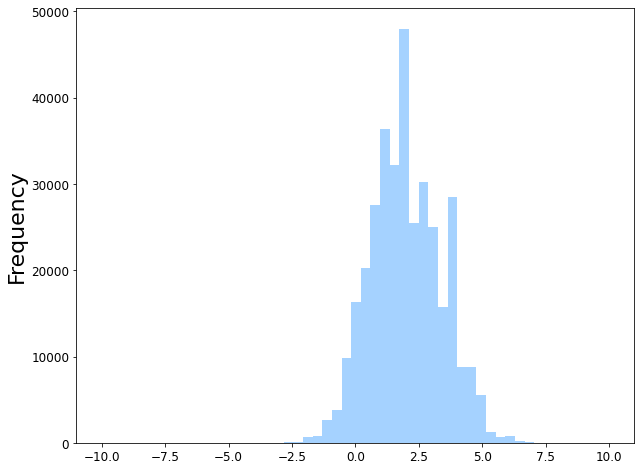

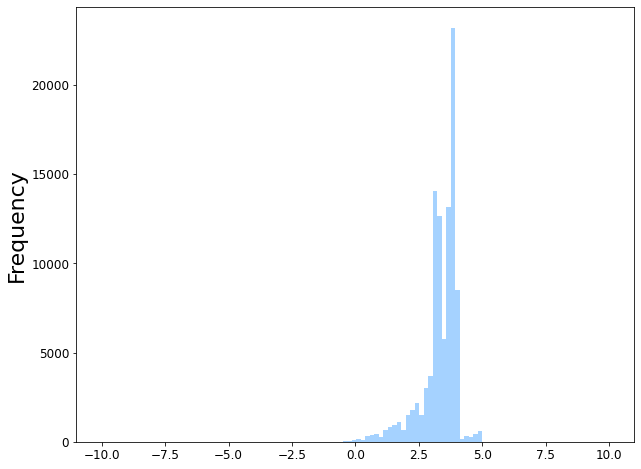

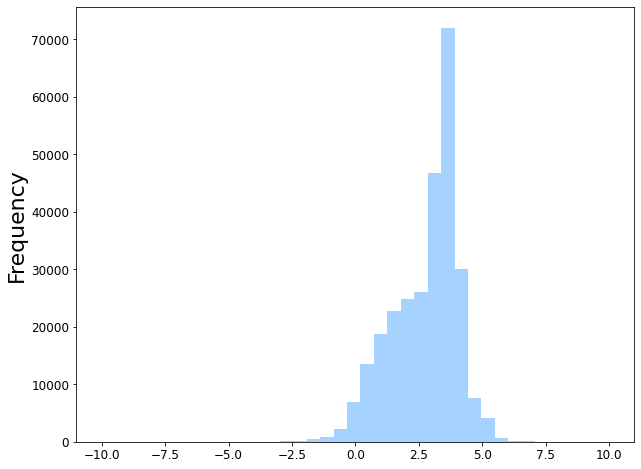

In [174]:
al = 0.2
lw = 2

hkdf[hkdf['DB'] == 'BindingDB']
hkdf[hkdf['DB'] == 'Metz']
hkdf[hkdf['DB'] == 'DTC']
plt.figure(figsize=(10, 8))
plt.hist(hkdf[hkdf['DB'] == 'BindingDB']['Value (log10nM)'].tolist(), 
         color="dodgerblue", alpha=0.4, bins=40)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-11, 11])
plt.show()

plt.figure(figsize=(10, 8))
plt.hist(hkdf[hkdf['DB'] == 'Metz']['Value (log10nM)'].tolist(), 
         color="dodgerblue", alpha=0.4, bins=40)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-11, 11])
plt.show()

plt.figure(figsize=(10, 8))
plt.hist(hkdf[hkdf['DB'] == 'DTC']['Value (log10nM)'].tolist(), 
         color="dodgerblue", alpha=0.4, bins=40)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-11, 11])
plt.show()

In [175]:
def getdunb(entry):
    msa = dunbrack[dunbrack['Entry'] == entry]['MSA'].iloc[0]
    pos = dunbrack[dunbrack['Entry'] == entry]['Position'].iloc[0]
    return msa, pos

In [176]:
dunbs = parmap.map(getdunb, hkdf['Entry'].tolist(), 
                   pm_pbar=True, pm_processes=100)

hkdf['MSA'] = [d[0] for d in dunbs]
hkdf['Position'] = [d[1] for d in dunbs]
hkdf

  0%|          | 0/727051 [00:00<?, ?it/s]

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       Q05397    PTK2_HUMAN   
2       O60674    JAK2_HUMAN   
3       P52333    JAK3_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
727046  P00533    EGFR_HUMAN   
727047  O60674    JAK2_HUMAN   
727048  O14757   CHEK1_HUMAN   
727049  O00444    PLK4_HUMAN   
727050  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...         =   
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
...                                                   ...       ...   
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  \
0          1033.14         3.014159  IC50  BindingDB   
1          1999.00         3.300813  IC50  BindingDB   
2            16.54         1.218536  IC50  BindingDB   
3           226.90         2.355834  IC50  BindingDB   
4          2999.00         3.476976  IC50  BindingDB   
...            ...              ...   ...        ...   
727046     1584.89         3.199999    Ki        DTC   
727047      794.33         2.900001    Ki        DTC   
727048     7943.28         3.900000    Ki        DTC   
727049     3162.28         3.500000    Ki        DTC   
727050    13000.00         4.113943    Ki        DTC   

                                                      MSA Position  
0       IELG----------------RCIGEGQ----------------FGD...  422-678  
1       IELG----------------RCIGEGQ----------------FGD...  422-678  
2       LIFN----------------ESLGQGT----------------FTK...  545-807  
3       LEWH----------------ENLGHGS----------------FTK...  521-779  
4       IELG----------------RCIGEGQ----------------FGD...  422-678  
...                                                   ...      ...  
727046  FKKI----------------KVLGSGA----------------FGT...  712-970  
727047  LIFN----------------ESLGQGT----------------FTK...  545-807  
727048  WDLV----------------QTLGEGA----------------YGE...    9-265  
727049  FKVG----------------NLLGKGS----------------FAG...   12-265  
727050  FERI----------------SELGAGN----------------GGV...   72-369  

[727051 rows x 10 columns]

In [177]:
def getcsmi(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        mols = rdmolops.GetMolFrags(m, asMols=True)
        m0 = max(mols, key=lambda m: m.GetNumAtoms())
        csmi = Chem.MolToSmiles(m0, isomericSmiles=True, canonical=True)
        return csmi
    except:
        return 0

In [178]:
csmi = parmap.map(getcsmi, hkdf['smiles'].tolist(), 
                  pm_pbar=True, pm_processes=100)

hkdf['SMILES'] = csmi
hkdf = hkdf[hkdf['SMILES'] != 0].reset_index(drop=True)
hkdf

  0%|          | 0/727051 [00:00<?, ?it/s]

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       Q05397    PTK2_HUMAN   
2       O60674    JAK2_HUMAN   
3       P52333    JAK3_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
727046  P00533    EGFR_HUMAN   
727047  O60674    JAK2_HUMAN   
727048  O14757   CHEK1_HUMAN   
727049  O00444    PLK4_HUMAN   
727050  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...         =   
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
...                                                   ...       ...   
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  \
0          1033.14         3.014159  IC50  BindingDB   
1          1999.00         3.300813  IC50  BindingDB   
2            16.54         1.218536  IC50  BindingDB   
3           226.90         2.355834  IC50  BindingDB   
4          2999.00         3.476976  IC50  BindingDB   
...            ...              ...   ...        ...   
727046     1584.89         3.199999    Ki        DTC   
727047      794.33         2.900001    Ki        DTC   
727048     7943.28         3.900000    Ki        DTC   
727049     3162.28         3.500000    Ki        DTC   
727050    13000.00         4.113943    Ki        DTC   

                                                      MSA Position  \
0       IELG----------------RCIGEGQ----------------FGD...  422-678   
1       IELG----------------RCIGEGQ----------------FGD...  422-678   
2       LIFN----------------ESLGQGT----------------FTK...  545-807   
3       LEWH----------------ENLGHGS----------------FTK...  521-779   
4       IELG----------------RCIGEGQ----------------FGD...  422-678   
...                                                   ...      ...   
727046  FKKI----------------KVLGSGA----------------FGT...  712-970   
727047  LIFN----------------ESLGQGT----------------FTK...  545-807   
727048  WDLV----------------QTLGEGA----------------YGE...    9-265   
727049  FKVG----------------NLLGKGS----------------FAG...   12-265   
727050  FERI----------------SELGAGN----------------GGV...   72-369   

                                                   SMILES  
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...  
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...  
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...  
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...  
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...  
...                                                   ...  
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C  
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C  
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C  
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C  
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...  

[727051 rows x 11 columns]

In [179]:
hkdf.shape[0], len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['SMILES'].tolist())))

(727051, 402, 176521)

In [180]:
# 부등호가 있는 데이터는 랜덤값을 더합니다.
# Data with an inequality sign adds random values.

In [181]:
def addrand(inputs):
    value, qualifier = inputs
    rand = np.random.rand()
    if qualifier == '=':
        return value
    elif qualifier == '>':
        return value+(rand*(int(value)+1)*0.01)
    elif qualifier == '<':
        return value-(rand*(int(value)+1)*0.01)

In [182]:
rands = parmap.map(addrand, [[v, q] for v, q in zip(hkdf['Value (log10nM)'].tolist(), hkdf['Qualifier'].tolist())], 
                   pm_pbar=True, pm_processes=100)

hkdf['Value (log10nM, +R)'] = rands
hkdf

  0%|          | 0/727051 [00:00<?, ?it/s]

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       Q05397    PTK2_HUMAN   
2       O60674    JAK2_HUMAN   
3       P52333    JAK3_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
727046  P00533    EGFR_HUMAN   
727047  O60674    JAK2_HUMAN   
727048  O14757   CHEK1_HUMAN   
727049  O00444    PLK4_HUMAN   
727050  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...         =   
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
...                                                   ...       ...   
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  \
0          1033.14         3.014159  IC50  BindingDB   
1          1999.00         3.300813  IC50  BindingDB   
2            16.54         1.218536  IC50  BindingDB   
3           226.90         2.355834  IC50  BindingDB   
4          2999.00         3.476976  IC50  BindingDB   
...            ...              ...   ...        ...   
727046     1584.89         3.199999    Ki        DTC   
727047      794.33         2.900001    Ki        DTC   
727048     7943.28         3.900000    Ki        DTC   
727049     3162.28         3.500000    Ki        DTC   
727050    13000.00         4.113943    Ki        DTC   

                                                      MSA Position  \
0       IELG----------------RCIGEGQ----------------FGD...  422-678   
1       IELG----------------RCIGEGQ----------------FGD...  422-678   
2       LIFN----------------ESLGQGT----------------FTK...  545-807   
3       LEWH----------------ENLGHGS----------------FTK...  521-779   
4       IELG----------------RCIGEGQ----------------FGD...  422-678   
...                                                   ...      ...   
727046  FKKI----------------KVLGSGA----------------FGT...  712-970   
727047  LIFN----------------ESLGQGT----------------FTK...  545-807   
727048  WDLV----------------QTLGEGA----------------YGE...    9-265   
727049  FKVG----------------NLLGKGS----------------FAG...   12-265   
727050  FERI----------------SELGAGN----------------GGV...   72-369   

                                                   SMILES  Value (log10nM, +R)  
0       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCNCC6)nc34)cc...             3.014159  
1       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...             3.300813  
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...             1.218536  
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...             2.355834  
4       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...             3.476976  
...                                                   ...                  ...  
727046             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C             3.199999  
727047             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C             2.900001  
727048             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C             3.931735  
727049             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C             3.500000  
727050  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...             4.113943  

[727051 rows x 12 columns]

In [183]:
# 위에서 랜덤값을 더했으므로 이 과정 이후 데이터 개수는 항상 다를 수 있습니다.
# Since we added random values above, the number of data points after this process can always be different.

In [184]:
# 중복 데이터는 아웃라이어 제거 후에 그들의 StD를 확인하고 합할 수 있는 경우는 평균으로 정리한다.
# Duplicate data are checked for their StD after outlier removal, and if they can be summed, they are averaged.

In [185]:
def mean_v(inputs):
    cid, entry, v, col = inputs
    
    def dropoutlier(df, column, rotat=1, weight=1.5):
        for i in range(rotat):
            quantile_25 = np.percentile(df[column].values, 25)
            quantile_75 = np.percentile(df[column].values, 75)
            IQR = quantile_75 - quantile_25
            IQR_weight = IQR*weight
            lowest = quantile_25 - IQR_weight
            highest = quantile_75 + IQR_weight
            df = df[(df[column] >= lowest) & (df[column] <= highest)].reset_index(drop=True)
        return df
    
    sample = hkdf[(hkdf['SMILES'] == cid) & (hkdf['Entry'] == entry)]
    vs = sample[col].tolist()
    if len(vs) > 1: # 값이 여러개인데
        sample = dropoutlier(sample, col)
        vs = sample[col].tolist()
        if np.std(vs) <= 0.25: # 값들이 너무 차이가 크면 버리고 어느정도 가까우면
            return np.mean(vs) # 평균
        else:
            return 'NaN'
    else:
        return v

In [186]:
meanvalue = parmap.map(mean_v, [[cid, entry, v, 'Value (log10nM, +R)'] for cid, entry, v in zip(hkdf['SMILES'].tolist(), 
                                                                                                hkdf['Entry'].tolist(), 
                                                                                                hkdf['Value (log10nM, +R)'].tolist())], 
                       pm_pbar=True, pm_processes=100)

hkdf['Mean Value (log10nM, +R)'] = meanvalue
hkdf = hkdf[hkdf['Mean Value (log10nM, +R)'] != 'NaN'].reset_index(drop=True)
hkdf = hkdf.dropna(subset=['Mean Value (log10nM, +R)']).reset_index(drop=True)
hkdf

  0%|          | 0/727051 [00:00<?, ?it/s]

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       O60674    JAK2_HUMAN   
2       P52333    JAK3_HUMAN   
3       O60674    JAK2_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
656707  P00533    EGFR_HUMAN   
656708  O60674    JAK2_HUMAN   
656709  O14757   CHEK1_HUMAN   
656710  O00444    PLK4_HUMAN   
656711  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =   
...                                                   ...       ...   
656707             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
656708             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
656709             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
656710             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
656711  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  \
0          1999.00         3.300813  IC50  BindingDB   
1            16.54         1.218536  IC50  BindingDB   
2           226.90         2.355834  IC50  BindingDB   
3            16.51         1.217747  IC50  BindingDB   
4          9999.00         3.999957  IC50  BindingDB   
...            ...              ...   ...        ...   
656707     1584.89         3.199999    Ki        DTC   
656708      794.33         2.900001    Ki        DTC   
656709     7943.28         3.900000    Ki        DTC   
656710     3162.28         3.500000    Ki        DTC   
656711    13000.00         4.113943    Ki        DTC   

                                                      MSA Position  \
0       IELG----------------RCIGEGQ----------------FGD...  422-678   
1       LIFN----------------ESLGQGT----------------FTK...  545-807   
2       LEWH----------------ENLGHGS----------------FTK...  521-779   
3       LIFN----------------ESLGQGT----------------FTK...  545-807   
4       IELG----------------RCIGEGQ----------------FGD...  422-678   
...                                                   ...      ...   
656707  FKKI----------------KVLGSGA----------------FGT...  712-970   
656708  LIFN----------------ESLGQGT----------------FTK...  545-807   
656709  WDLV----------------QTLGEGA----------------YGE...    9-265   
656710  FKVG----------------NLLGKGS----------------FAG...   12-265   
656711  FERI----------------SELGAGN----------------GGV...   72-369   

                                                   SMILES  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...   
...                                                   ...   
656707             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656708             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656709             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656710             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656711  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...   

        Value (log10nM, +R) Mean Value (log10nM, +R)  
0                  3.300813                 3.300813  
1                  1.218536                 1.218141  
2                  2.355834                 2.355834  
3                  1.217747                 1.218141  
4                  3.999957                 3.999957  
...                     ...                      ...  
656707             3.199999                      3.2  
656708             2.900001                      2.9  
656709             3.931735  

In [187]:
hkdf.to_csv('hkdf_total_data.csv', index=False)

In [188]:
hkdf = pd.read_csv('hkdf_total_data.csv')
hkdf

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       O60674    JAK2_HUMAN   
2       P52333    JAK3_HUMAN   
3       O60674    JAK2_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
656707  P00533    EGFR_HUMAN   
656708  O60674    JAK2_HUMAN   
656709  O14757   CHEK1_HUMAN   
656710  O00444    PLK4_HUMAN   
656711  P36507  MAP2K2_HUMAN   

                                                   smiles Qualifier  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =   
...                                                   ...       ...   
656707             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
656708             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
656709             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         >   
656710             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C         =   
656711  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...         =   

        Value (nM)  Value (log10nM)  Type         DB  \
0          1999.00         3.300813  IC50  BindingDB   
1            16.54         1.218536  IC50  BindingDB   
2           226.90         2.355834  IC50  BindingDB   
3            16.51         1.217747  IC50  BindingDB   
4          9999.00         3.999957  IC50  BindingDB   
...            ...              ...   ...        ...   
656707     1584.89         3.199999    Ki        DTC   
656708      794.33         2.900001    Ki        DTC   
656709     7943.28         3.900000    Ki        DTC   
656710     3162.28         3.500000    Ki        DTC   
656711    13000.00         4.113943    Ki        DTC   

                                                      MSA Position  \
0       IELG----------------RCIGEGQ----------------FGD...  422-678   
1       LIFN----------------ESLGQGT----------------FTK...  545-807   
2       LEWH----------------ENLGHGS----------------FTK...  521-779   
3       LIFN----------------ESLGQGT----------------FTK...  545-807   
4       IELG----------------RCIGEGQ----------------FGD...  422-678   
...                                                   ...      ...   
656707  FKKI----------------KVLGSGA----------------FGT...  712-970   
656708  LIFN----------------ESLGQGT----------------FTK...  545-807   
656709  WDLV----------------QTLGEGA----------------YGE...    9-265   
656710  FKVG----------------NLLGKGS----------------FAG...   12-265   
656711  FERI----------------SELGAGN----------------GGV...   72-369   

                                                   SMILES  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...   
...                                                   ...   
656707             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656708             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656709             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656710             CCCCCCCCCCCCCCCC[n+]1ccn(Cc2ccccc2)c1C   
656711  CN1C(=O)NC(=O)C12Cc1ccc(NC(=O)CN(Cc3cccc(C#N)c...   

        Value (log10nM, +R)  Mean Value (log10nM, +R)  
0                  3.300813                  3.300813  
1                  1.218536                  1.218141  
2                  2.355834                  2.355834  
3                  1.217747                  1.218141  
4                  3.999957                  3.999957  
...                     ...                       ...  
656707             3.199999                  3.200000  
656708             2.900001                  2.900000  
656709             3

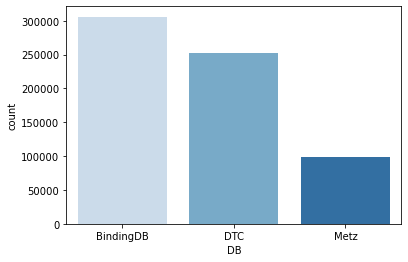

- 'BindingDB' : 305967
- 'DTC' : 252641
- 'Metz' : 98104


In [189]:
sns.countplot(x='DB', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['DB']).index.tolist(), hkdf.value_counts(['DB']).tolist()):
    print(f"- '{t[0]}' : {c}")

In [190]:
# 데이터가 많은 기준으로 우선순위를 정해서 다시 정렬한다.
# Prioritize and rearrange data based on a lot of data.

In [191]:
hkdf1 = hkdf[hkdf['DB'] == 'BindingDB'].reset_index(drop=True).reset_index(drop=True)
hkdf2 = hkdf[hkdf['DB'] == 'DTC'].reset_index(drop=True).reset_index(drop=True)
hkdf3 = hkdf[hkdf['DB'] == 'Metz'].reset_index(drop=True).reset_index(drop=True)
hkdf1.shape[0], hkdf2.shape[0], hkdf3.shape[0]

(305967, 252641, 98104)

In [192]:
hkdf = pd.concat([hkdf1, hkdf2, hkdf3]).reset_index(drop=True)
hkdf

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       O60674    JAK2_HUMAN   
2       P52333    JAK3_HUMAN   
3       O60674    JAK2_HUMAN   
4       Q05397    PTK2_HUMAN   
...        ...           ...   
656707  Q9UQM7  CAMK2A_HUMAN   
656708  Q00535    CDK5_HUMAN   
656709  P00519    ABL1_HUMAN   
656710  Q07912    TNK2_HUMAN   
656711  Q04771   ACVR1_HUMAN   

                                                   smiles Qualifier  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =   
...                                                   ...       ...   
656707                        Brc1ccc2cnc(Nc3ccncn3)cc2c1         <   
656708                        Brc1ccc2cnc(Nc3ccncn3)cc2c1         =   
656709                        Brc1ccc2cnc(Nc3ccncn3)cc2c1         <   
656710                        Brc1ccc2cnc(Nc3ccncn3)cc2c1         <   
656711                        Brc1ccc2cnc(Nc3ccncn3)cc2c1         <   

         Value (nM)  Value (log10nM)  Type         DB  \
0       1999.000000         3.300813  IC50  BindingDB   
1         16.540000         1.218536  IC50  BindingDB   
2        226.900000         2.355834  IC50  BindingDB   
3         16.510000         1.217747  IC50  BindingDB   
4       9999.000000         3.999957  IC50  BindingDB   
...             ...              ...   ...        ...   
656707  3981.071706         3.600000    Ki       Metz   
656708   158.489319         2.200000    Ki       Metz   
656709  2511.886432         3.400000    Ki       Metz   
656710  3981.071706         3.600000    Ki       Metz   
656711  3981.071706         3.600000    Ki       Metz   

                                                      MSA Position  \
0       IELG----------------RCIGEGQ----------------FGD...  422-678   
1       LIFN----------------ESLGQGT----------------FTK...  545-807   
2       LEWH----------------ENLGHGS----------------FTK...  521-779   
3       LIFN----------------ESLGQGT----------------FTK...  545-807   
4       IELG----------------RCIGEGQ----------------FGD...  422-678   
...                                                   ...      ...   
656707  YQLF----------------EELGKGA----------------FSV...   13-271   
656708  YEKL----------------EKIGEGT----------------YGT...    4-286   
656709  ITMK----------------HKLGGGQ----------------YGE...  242-495   
656710  LRLL----------------EKLGDGS----------------FGV...  126-387   
656711  ITLL----------------ECVGKGR----------------YGE...  208-497   

                                                   SMILES  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
3       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...   
...                                                   ...   
656707                        Brc1ccc2cnc(Nc3ccncn3)cc2c1   
656708                        Brc1ccc2cnc(Nc3ccncn3)cc2c1   
656709                        Brc1ccc2cnc(Nc3ccncn3)cc2c1   
656710                        Brc1ccc2cnc(Nc3ccncn3)cc2c1   
656711                        Brc1ccc2cnc(Nc3ccncn3)cc2c1   

        Value (log10nM, +R)  Mean Value (log10nM, +R)  
0                  3.300813                  3.300813  
1                  1.218536                  1.218141  
2                  2.355834                  2.355834  
3                  1.217747                  1.218141  
4                  3.999957                  3.999957  
...                     ...                       ...  
656707             3.574100                  3.598575  
656708             2.200000                  2.200001  
656709  

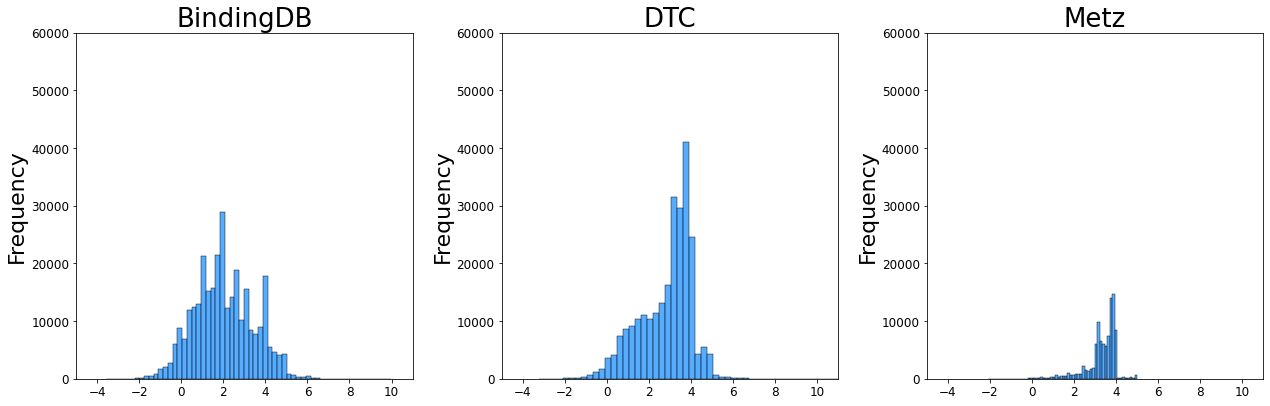

In [193]:
al = 0.2

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('BindingDB', fontsize=26)
sns.histplot(hkdf[hkdf['DB'] == 'BindingDB']['Value (log10nM)'].tolist(), color="dodgerblue", bins=60)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 60000])

plt.subplot(1, 3, 2)
plt.title('DTC', fontsize=26)
sns.histplot(hkdf[hkdf['DB'] == 'DTC']['Value (log10nM)'].tolist(), color="dodgerblue", bins=60)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 60000])

plt.subplot(1, 3, 3)
plt.title('Metz', fontsize=26)
sns.histplot(hkdf[hkdf['DB'] == 'Metz']['Value (log10nM)'].tolist(), color="dodgerblue", bins=60)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 60000])

plt.tight_layout(pad=2)
plt.show()

In [194]:
# 중복을 제거한다.
# Eliminate duplicates.

In [195]:
hkdf = hkdf.drop_duplicates(['Entry', 'SMILES'], keep='first').reset_index(drop=True)
hkdf

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       O60674    JAK2_HUMAN   
2       P52333    JAK3_HUMAN   
3       Q05397    PTK2_HUMAN   
4       O60674    JAK2_HUMAN   
...        ...           ...   
385266  Q9UQM7  CAMK2A_HUMAN   
385267  P00519    ABL1_HUMAN   
385268  Q07912    TNK2_HUMAN   
385269  Q04771   ACVR1_HUMAN   
385270  O00141    SGK1_HUMAN   

                                                   smiles Qualifier  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =   
...                                                   ...       ...   
385266  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385267  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385268  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385269  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         <   

          Value (nM)  Value (log10nM)  Type         DB  \
0        1999.000000         3.300813  IC50  BindingDB   
1          16.540000         1.218536  IC50  BindingDB   
2         226.900000         2.355834  IC50  BindingDB   
3        9999.000000         3.999957  IC50  BindingDB   
4        9999.000000         3.999957  IC50  BindingDB   
...              ...              ...   ...        ...   
385266   3981.071706         3.600000    Ki       Metz   
385267   2511.886432         3.400000    Ki       Metz   
385268   3981.071706         3.600000    Ki       Metz   
385269   3981.071706         3.600000    Ki       Metz   
385270  10000.000000         4.000000    Ki       Metz   

                                                      MSA Position  \
0       IELG----------------RCIGEGQ----------------FGD...  422-678   
1       LIFN----------------ESLGQGT----------------FTK...  545-807   
2       LEWH----------------ENLGHGS----------------FTK...  521-779   
3       IELG----------------RCIGEGQ----------------FGD...  422-678   
4       LIFN----------------ESLGQGT----------------FTK...  545-807   
...                                                   ...      ...   
385266  YQLF----------------EELGKGA----------------FSV...   13-271   
385267  ITMK----------------HKLGGGQ----------------YGE...  242-495   
385268  LRLL----------------EKLGDGS----------------FGV...  126-387   
385269  ITLL----------------ECVGKGR----------------YGE...  208-497   
385270  FHFL----------------KVIGKGS----------------FGK...   98-355   

                                                   SMILES  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
3       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...   
...                                                   ...   
385266  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385267  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385268  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385269  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N   

        Value (log10nM, +R)  Mean Value (log10nM, +R)  
0                  3.300813                  3.300813  
1                  1.218536                  1.218141  
2                  2.355834                  2.355834  
3                  3.999957                  3.999957  
4                  3.999957                  3.999957  
...                     ...                       ...  
385266             3.564579                  3.564579  
385267             3.364789                  3.36478

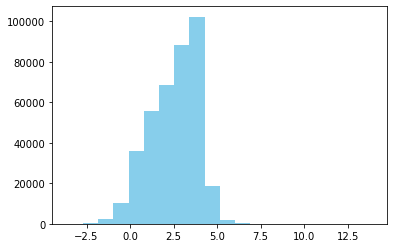

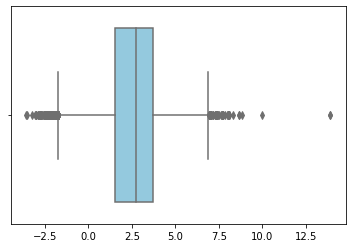

-3.59 13.9


In [196]:
v_list = hkdf['Mean Value (log10nM, +R)'].tolist()

plt.hist(v_list, bins=20, color='skyblue')
plt.show()

sns.boxplot(x=v_list, color='skyblue')
plt.show()

print(round(min(v_list), 2), round(max(v_list), 2))

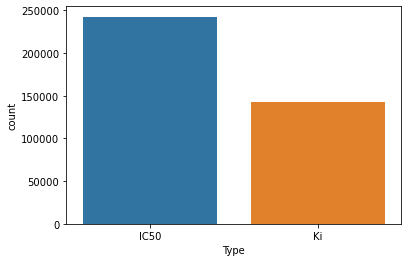

- IC50 : 242434
- Ki : 142837


In [197]:
sns.countplot(x='Type', data=hkdf)
plt.show()

for t, c in zip(hkdf.value_counts(['Type']).index.tolist(), hkdf.value_counts(['Type']).tolist()):
    print(f'- {t[0]} : {c}')

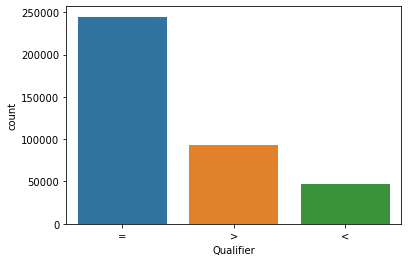

- '=' : 244693
- '>' : 93473
- '<' : 47105


In [198]:
sns.countplot(x='Qualifier', data=hkdf)
plt.show()

for t, c in zip(hkdf.value_counts(['Qualifier']).index.tolist(), hkdf.value_counts(['Qualifier']).tolist()):
    print(f"- '{t[0]}' : {c}")

In [199]:
hkdf.to_csv('humankinase_data.csv', index=False)

In [200]:
hkdf = pd.read_csv('humankinase_data.csv')
hkdf

Entry          Name  \
0       Q05397    PTK2_HUMAN   
1       O60674    JAK2_HUMAN   
2       P52333    JAK3_HUMAN   
3       Q05397    PTK2_HUMAN   
4       O60674    JAK2_HUMAN   
...        ...           ...   
385266  Q9UQM7  CAMK2A_HUMAN   
385267  P00519    ABL1_HUMAN   
385268  Q07912    TNK2_HUMAN   
385269  Q04771   ACVR1_HUMAN   
385270  O00141    SGK1_HUMAN   

                                                   smiles Qualifier  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =   
3       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =   
...                                                   ...       ...   
385266  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385267  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385268  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385269  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         <   

          Value (nM)  Value (log10nM)  Type         DB  \
0        1999.000000         3.300813  IC50  BindingDB   
1          16.540000         1.218536  IC50  BindingDB   
2         226.900000         2.355834  IC50  BindingDB   
3        9999.000000         3.999957  IC50  BindingDB   
4        9999.000000         3.999957  IC50  BindingDB   
...              ...              ...   ...        ...   
385266   3981.071706         3.600000    Ki       Metz   
385267   2511.886432         3.400000    Ki       Metz   
385268   3981.071706         3.600000    Ki       Metz   
385269   3981.071706         3.600000    Ki       Metz   
385270  10000.000000         4.000000    Ki       Metz   

                                                      MSA Position  \
0       IELG----------------RCIGEGQ----------------FGD...  422-678   
1       LIFN----------------ESLGQGT----------------FTK...  545-807   
2       LEWH----------------ENLGHGS----------------FTK...  521-779   
3       IELG----------------RCIGEGQ----------------FGD...  422-678   
4       LIFN----------------ESLGQGT----------------FTK...  545-807   
...                                                   ...      ...   
385266  YQLF----------------EELGKGA----------------FSV...   13-271   
385267  ITMK----------------HKLGGGQ----------------YGE...  242-495   
385268  LRLL----------------EKLGDGS----------------FGV...  126-387   
385269  ITLL----------------ECVGKGR----------------YGE...  208-497   
385270  FHFL----------------KVIGKGS----------------FGK...   98-355   

                                                   SMILES  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...   
3       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...   
...                                                   ...   
385266  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385267  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385268  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385269  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N   

        Value (log10nM, +R)  Mean Value (log10nM, +R)  
0                  3.300813                  3.300813  
1                  1.218536                  1.218141  
2                  2.355834                  2.355834  
3                  3.999957                  3.999957  
4                  3.999957                  3.999957  
...                     ...                       ...  
385266             3.564579                  3.564579  
385267             3.364789                  3.36478

In [201]:
hkdf = hkdf[['Entry', 'Name', 'Position', 'MSA', 'SMILES', 'Qualifier', 'Type', 'Value (nM)', 'Mean Value (log10nM, +R)', 'DB']]
hkdf = hkdf.rename(columns={'Mean Value (log10nM, +R)':'Value'})
hkdf = hkdf.rename(columns={'DB':'Database'})
hkdf

Entry          Name Position  \
0       Q05397    PTK2_HUMAN  422-678   
1       O60674    JAK2_HUMAN  545-807   
2       P52333    JAK3_HUMAN  521-779   
3       Q05397    PTK2_HUMAN  422-678   
4       O60674    JAK2_HUMAN  545-807   
...        ...           ...      ...   
385266  Q9UQM7  CAMK2A_HUMAN   13-271   
385267  P00519    ABL1_HUMAN  242-495   
385268  Q07912    TNK2_HUMAN  126-387   
385269  Q04771   ACVR1_HUMAN  208-497   
385270  O00141    SGK1_HUMAN   98-355   

                                                      MSA  \
0       IELG----------------RCIGEGQ----------------FGD...   
1       LIFN----------------ESLGQGT----------------FTK...   
2       LEWH----------------ENLGHGS----------------FTK...   
3       IELG----------------RCIGEGQ----------------FGD...   
4       LIFN----------------ESLGQGT----------------FTK...   
...                                                   ...   
385266  YQLF----------------EELGKGA----------------FSV...   
385267  ITMK----------------HKLGGGQ----------------YGE...   
385268  LRLL----------------EKLGDGS----------------FGV...   
385269  ITLL----------------ECVGKGR----------------YGE...   
385270  FHFL----------------KVIGKGS----------------FGK...   

                                                   SMILES Qualifier  Type  \
0       CN(C)C(=O)N1CCc2ccc(Nc3nc4c(-c5cc(Cl)ccc5OCC(F...         =  IC50   
1       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =  IC50   
2       Cn1ncc2c(-c3cccn4nc(Nc5ccc6c(c5)CCN(C(=O)OC(C)...         =  IC50   
3       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =  IC50   
4       C=Cc1nc(NC(=O)Nc2ccc(N3CCNCC3)cc2)nn1C(=C)c1cc...         =  IC50   
...                                                   ...       ...   ...   
385266  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <    Ki   
385267  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <    Ki   
385268  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <    Ki   
385269  CCc1cnn2c(NCc3ccc[n+]([O-])c3)cc(N3CCCC[C@H]3C...         <    Ki   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         <    Ki   

          Value (nM)     Value   Database  
0        1999.000000  3.300813  BindingDB  
1          16.540000  1.218141  BindingDB  
2         226.900000  2.355834  BindingDB  
3        9999.000000  3.999957  BindingDB  
4        9999.000000  3.999957  BindingDB  
...              ...       ...        ...  
385266   3981.071706  3.564579       Metz  
385267   2511.886432  3.364789       Metz  
385268   3981.071706  3.579861       Metz  
385269   3981.071706  3.585759       Metz  
385270  10000.000000  3.950147       Metz  

[385271 rows x 10 columns]

In [202]:
hkdf = hkdf.sort_values(['Entry']).reset_index(drop=True)
hkdf = hkdf.sort_values(['Database']).reset_index(drop=True)
hkdf

Entry          Name  Position  \
0       P35968     KDR_HUMAN  834-1162   
1       P45983   MAPK8_HUMAN    26-321   
2       P45983   MAPK8_HUMAN    26-321   
3       P45983   MAPK8_HUMAN    26-321   
4       P45983   MAPK8_HUMAN    26-321   
...        ...           ...       ...   
385266  P16234  PDGFRA_HUMAN   593-952   
385267  Q06187     BTK_HUMAN   402-653   
385268  Q06187     BTK_HUMAN   402-653   
385269  P51451     BLK_HUMAN   241-492   
385270  O00141    SGK1_HUMAN    98-355   

                                                      MSA  \
0       LKLG----------------KPLGRGA----------------FGQ...   
1       YQNL----------------KPIGSGA----------------QGI...   
2       YQNL----------------KPIGSGA----------------QGI...   
3       YQNL----------------KPIGSGA----------------QGI...   
4       YQNL----------------KPIGSGA----------------QGI...   
...                                                   ...   
385266  LVLG----------------RVLGSGA----------------FGK...   
385267  LTFL----------------KELGTGQ----------------FGV...   
385268  LTFL----------------KELGTGQ----------------FGV...   
385269  LRLV----------------RKLGSGQ----------------FGE...   
385270  FHFL----------------KVIGKGS----------------FGK...   

                                                   SMILES Qualifier  Type  \
0        COc1cc2c(Nc3c(Cl)ccc4ccoc34)ncnc2cc1OCCCN1CCOCC1         =  IC50   
1       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
2       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
3       CCNC(=O)n1cc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...         =  IC50   
4       CCNC(=O)n1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl...         =  IC50   
...                                                   ...       ...   ...   
385266    CCn1c(-c2nonc2N)nc2cncc(C(=O)N3CC[C@H](N)C3)c21         <    Ki   
385267  Cc1n[nH]c2cnc(-c3cncc(OC[C@@H](N)Cc4cccc(C(F)(...         <    Ki   
385268  Nc1ccc(-c2cncc(OC[C@@H](N)Cc3c[nH]c4ccccc34)c2...         <    Ki   
385269    CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1         =    Ki   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         <    Ki   

          Value (nM)     Value   Database  
0        1380.000000  3.139879  BindingDB  
1           7.300000  0.863323  BindingDB  
2          33.000000  1.518514  BindingDB  
3          43.000000  1.633468  BindingDB  
4           8.600000  0.934498  BindingDB  
...              ...       ...        ...  
385266   2511.886432  3.372616       Metz  
385267   1258.925412  3.081404       Metz  
385268   1258.925412  3.061480       Metz  
385269    501.187234  2.700000       Metz  
385270  10000.000000  3.950147       Metz  

[385271 rows x 10 columns]

In [203]:
len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['Name'].tolist()))), len(list(set(hkdf['MSA'].tolist())))

(402, 402, 402)

In [204]:
len(list(set(hkdf['SMILES'].tolist())))

167927

In [205]:
hkdf.to_csv('kpro_data_total2.csv', index=False)

In [206]:
hkdf = pd.read_csv('kpro_data_total2.csv', low_memory=False)
hkdf

Entry          Name  Position  \
0       P35968     KDR_HUMAN  834-1162   
1       P45983   MAPK8_HUMAN    26-321   
2       P45983   MAPK8_HUMAN    26-321   
3       P45983   MAPK8_HUMAN    26-321   
4       P45983   MAPK8_HUMAN    26-321   
...        ...           ...       ...   
385266  P16234  PDGFRA_HUMAN   593-952   
385267  Q06187     BTK_HUMAN   402-653   
385268  Q06187     BTK_HUMAN   402-653   
385269  P51451     BLK_HUMAN   241-492   
385270  O00141    SGK1_HUMAN    98-355   

                                                      MSA  \
0       LKLG----------------KPLGRGA----------------FGQ...   
1       YQNL----------------KPIGSGA----------------QGI...   
2       YQNL----------------KPIGSGA----------------QGI...   
3       YQNL----------------KPIGSGA----------------QGI...   
4       YQNL----------------KPIGSGA----------------QGI...   
...                                                   ...   
385266  LVLG----------------RVLGSGA----------------FGK...   
385267  LTFL----------------KELGTGQ----------------FGV...   
385268  LTFL----------------KELGTGQ----------------FGV...   
385269  LRLV----------------RKLGSGQ----------------FGE...   
385270  FHFL----------------KVIGKGS----------------FGK...   

                                                   SMILES Qualifier  Type  \
0        COc1cc2c(Nc3c(Cl)ccc4ccoc34)ncnc2cc1OCCCN1CCOCC1         =  IC50   
1       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
2       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
3       CCNC(=O)n1cc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...         =  IC50   
4       CCNC(=O)n1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl...         =  IC50   
...                                                   ...       ...   ...   
385266    CCn1c(-c2nonc2N)nc2cncc(C(=O)N3CC[C@H](N)C3)c21         <    Ki   
385267  Cc1n[nH]c2cnc(-c3cncc(OC[C@@H](N)Cc4cccc(C(F)(...         <    Ki   
385268  Nc1ccc(-c2cncc(OC[C@@H](N)Cc3c[nH]c4ccccc34)c2...         <    Ki   
385269    CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1         =    Ki   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         <    Ki   

          Value (nM)     Value   Database  
0        1380.000000  3.139879  BindingDB  
1           7.300000  0.863323  BindingDB  
2          33.000000  1.518514  BindingDB  
3          43.000000  1.633468  BindingDB  
4           8.600000  0.934498  BindingDB  
...              ...       ...        ...  
385266   2511.886432  3.372616       Metz  
385267   1258.925412  3.081404       Metz  
385268   1258.925412  3.061480       Metz  
385269    501.187234  2.700000       Metz  
385270  10000.000000  3.950147       Metz  

[385271 rows x 10 columns]

In [207]:
TAG = "umols"
fn_l_midsmi = "kpro_data_total2.csv"
um = Umols(TAG)
um.Read_l_midsmi(fn_l_midsmi, col_mid='SMILES', col_smi='SMILES', sep=',')
um.Clean()
um.Dump(TAG)

In [208]:
fp = open("%s/umols.pickle" % TAG, 'rb')
tag = cPickle.load(fp)
bool_chkin = cPickle.load(fp)
bool_clean = cPickle.load(fp)
l_midsmi = cPickle.load(fp)
l_cln_midcsmi = cPickle.load(fp)
l_cln_mids = cPickle.load(fp)
l_cln_csmi = cPickle.load(fp)
l_uniq_csmi = cPickle.load(fp)
l_skip_mids = cPickle.load(fp)
d_cln_mid2csmi = cPickle.load(fp)
d_cln_csmi2mids = cPickle.load(fp)
fp.close()

In [209]:
def getsmi(smi):
    m = Chem.MolFromSmiles(smi)
    mols = rdmolops.GetMolFrags(m, asMols=True)
    m0 = max(mols, key=lambda m: m.GetNumAtoms())
    csmi = Chem.MolToSmiles(m0, isomericSmiles=True, canonical=True)
    if csmi in l_uniq_csmi:
        return Chem.MolToSmiles(Chem.MolFromSmiles(csmi))
    else:
        return 0

In [210]:
smi = parmap.map(getsmi, hkdf['SMILES'].tolist(), pm_pbar=True, pm_processes=100)

hkdf['SMILES'] = smi
hkdf = hkdf[hkdf['SMILES'] != 0].reset_index(drop=True)
hkdf

  0%|          | 0/385271 [00:00<?, ?it/s]

Entry          Name  Position  \
0       P35968     KDR_HUMAN  834-1162   
1       P45983   MAPK8_HUMAN    26-321   
2       P45983   MAPK8_HUMAN    26-321   
3       P45983   MAPK8_HUMAN    26-321   
4       P45983   MAPK8_HUMAN    26-321   
...        ...           ...       ...   
385266  P16234  PDGFRA_HUMAN   593-952   
385267  Q06187     BTK_HUMAN   402-653   
385268  Q06187     BTK_HUMAN   402-653   
385269  P51451     BLK_HUMAN   241-492   
385270  O00141    SGK1_HUMAN    98-355   

                                                      MSA  \
0       LKLG----------------KPLGRGA----------------FGQ...   
1       YQNL----------------KPIGSGA----------------QGI...   
2       YQNL----------------KPIGSGA----------------QGI...   
3       YQNL----------------KPIGSGA----------------QGI...   
4       YQNL----------------KPIGSGA----------------QGI...   
...                                                   ...   
385266  LVLG----------------RVLGSGA----------------FGK...   
385267  LTFL----------------KELGTGQ----------------FGV...   
385268  LTFL----------------KELGTGQ----------------FGV...   
385269  LRLV----------------RKLGSGQ----------------FGE...   
385270  FHFL----------------KVIGKGS----------------FGK...   

                                                   SMILES Qualifier  Type  \
0        COc1cc2c(Nc3c(Cl)ccc4ccoc34)ncnc2cc1OCCCN1CCOCC1         =  IC50   
1       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
2       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
3       CCNC(=O)n1cc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...         =  IC50   
4       CCNC(=O)n1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl...         =  IC50   
...                                                   ...       ...   ...   
385266    CCn1c(-c2nonc2N)nc2cncc(C(=O)N3CC[C@H](N)C3)c21         <    Ki   
385267  Cc1n[nH]c2cnc(-c3cncc(OC[C@@H](N)Cc4cccc(C(F)(...         <    Ki   
385268  Nc1ccc(-c2cncc(OC[C@@H](N)Cc3c[nH]c4ccccc34)c2...         <    Ki   
385269    CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1         =    Ki   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         <    Ki   

          Value (nM)     Value   Database  
0        1380.000000  3.139879  BindingDB  
1           7.300000  0.863323  BindingDB  
2          33.000000  1.518514  BindingDB  
3          43.000000  1.633468  BindingDB  
4           8.600000  0.934498  BindingDB  
...              ...       ...        ...  
385266   2511.886432  3.372616       Metz  
385267   1258.925412  3.081404       Metz  
385268   1258.925412  3.061480       Metz  
385269    501.187234  2.700000       Metz  
385270  10000.000000  3.950147       Metz  

[385271 rows x 10 columns]

In [211]:
print('- Data', hkdf.shape[0])
print('- Kinase', len(list(set(hkdf['Entry'].unique()))))
print('- Compound', len(list(set(hkdf['SMILES'].unique()))))

- Data 385271
- Kinase 402
- Compound 167927


In [212]:
# 후보물질이 될만한 분자만 남긴다.
# Only molecules that can be candidates are left.

In [213]:
hkdf.to_csv("./kpro_data_total_final2.csv", index=False)

In [214]:
hkdf = pd.read_csv("./kpro_data_total_final2.csv")
hkdf

Entry          Name  Position  \
0       P35968     KDR_HUMAN  834-1162   
1       P45983   MAPK8_HUMAN    26-321   
2       P45983   MAPK8_HUMAN    26-321   
3       P45983   MAPK8_HUMAN    26-321   
4       P45983   MAPK8_HUMAN    26-321   
...        ...           ...       ...   
385266  P16234  PDGFRA_HUMAN   593-952   
385267  Q06187     BTK_HUMAN   402-653   
385268  Q06187     BTK_HUMAN   402-653   
385269  P51451     BLK_HUMAN   241-492   
385270  O00141    SGK1_HUMAN    98-355   

                                                      MSA  \
0       LKLG----------------KPLGRGA----------------FGQ...   
1       YQNL----------------KPIGSGA----------------QGI...   
2       YQNL----------------KPIGSGA----------------QGI...   
3       YQNL----------------KPIGSGA----------------QGI...   
4       YQNL----------------KPIGSGA----------------QGI...   
...                                                   ...   
385266  LVLG----------------RVLGSGA----------------FGK...   
385267  LTFL----------------KELGTGQ----------------FGV...   
385268  LTFL----------------KELGTGQ----------------FGV...   
385269  LRLV----------------RKLGSGQ----------------FGE...   
385270  FHFL----------------KVIGKGS----------------FGK...   

                                                   SMILES Qualifier  Type  \
0        COc1cc2c(Nc3c(Cl)ccc4ccoc34)ncnc2cc1OCCCN1CCOCC1         =  IC50   
1       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
2       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
3       CCNC(=O)n1cc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...         =  IC50   
4       CCNC(=O)n1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl...         =  IC50   
...                                                   ...       ...   ...   
385266    CCn1c(-c2nonc2N)nc2cncc(C(=O)N3CC[C@H](N)C3)c21         <    Ki   
385267  Cc1n[nH]c2cnc(-c3cncc(OC[C@@H](N)Cc4cccc(C(F)(...         <    Ki   
385268  Nc1ccc(-c2cncc(OC[C@@H](N)Cc3c[nH]c4ccccc34)c2...         <    Ki   
385269    CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1         =    Ki   
385270              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         <    Ki   

          Value (nM)     Value   Database  
0        1380.000000  3.139879  BindingDB  
1           7.300000  0.863323  BindingDB  
2          33.000000  1.518514  BindingDB  
3          43.000000  1.633468  BindingDB  
4           8.600000  0.934498  BindingDB  
...              ...       ...        ...  
385266   2511.886432  3.372616       Metz  
385267   1258.925412  3.081404       Metz  
385268   1258.925412  3.061480       Metz  
385269    501.187234  2.700000       Metz  
385270  10000.000000  3.950147       Metz  

[385271 rows x 10 columns]

In [215]:
print('- Data', hkdf.shape[0])
print('- Kinase', len(list(set(hkdf['Entry'].unique()))))
print('- Compound', len(list(set(hkdf['SMILES'].unique()))))

- Data 385271
- Kinase 402
- Compound 167927


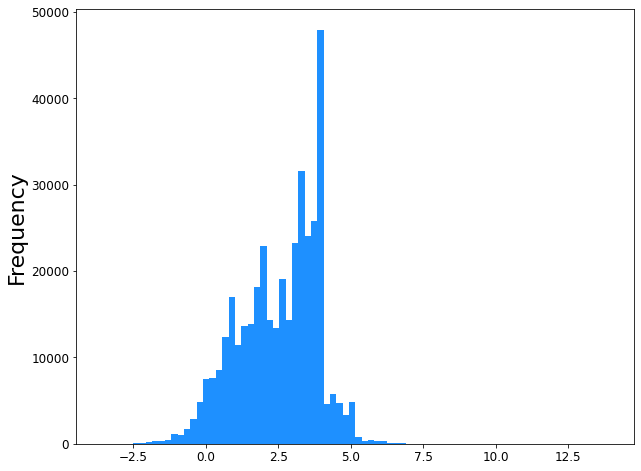

In [216]:
al = 0.2
lw = 2

plt.figure(figsize=(10, 8))
plt.hist(hkdf['Value'].tolist(), 
         color="dodgerblue", bins=80)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim([-11, 11])
plt.show()

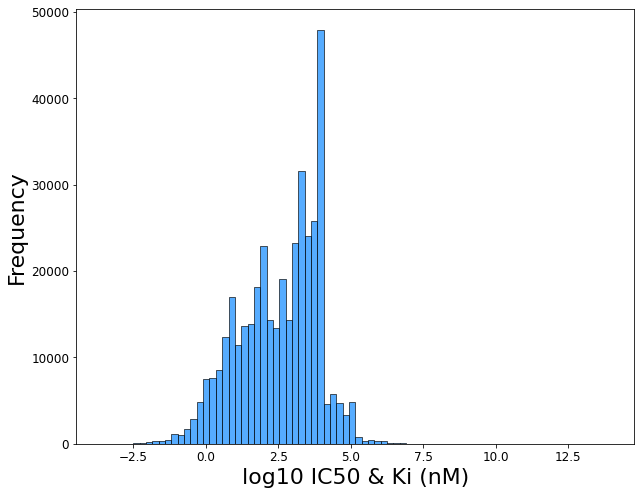

In [217]:
al = 0.2
lw = 2

plt.figure(figsize=(10, 8))
sns.histplot(hkdf['Value'].tolist(), color="dodgerblue", bins=80)
plt.ylabel('Frequency', fontsize=22)
plt.xlabel('log10 IC50 & Ki (nM)', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim([-11, 11])
plt.show()

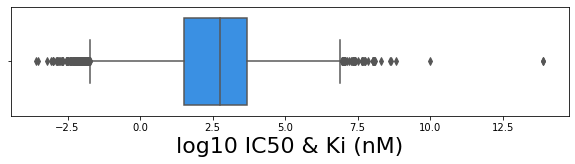

-3.59 13.9


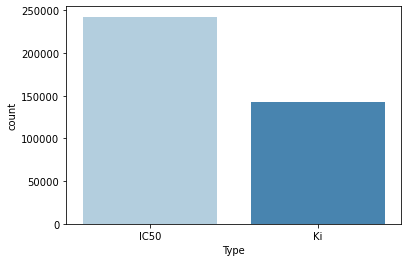

- IC50 : 242434
- Ki : 142837


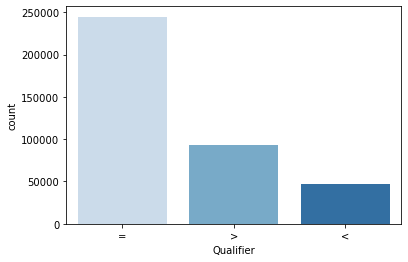

- '=' : 244693
- '>' : 93473
- '<' : 47105


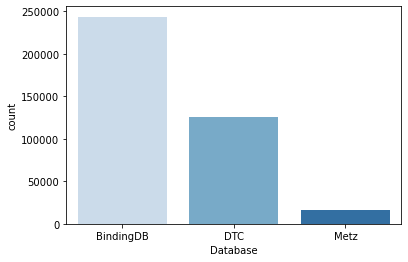

- 'BindingDB' : 243657
- 'DTC' : 125831
- 'Metz' : 15783


In [218]:
v_list = hkdf['Value'].tolist()

plt.figure(figsize=(10, 2))

sns.boxplot(x=v_list, color='dodgerblue')
plt.xlabel('log10 IC50 & Ki (nM)', fontsize=22)
plt.show()

print(round(min(v_list), 2), round(max(v_list), 2))

sns.countplot(x='Type', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['Type']).index.tolist(), hkdf.value_counts(['Type']).tolist()):
    print(f'- {t[0]} : {c}')

sns.countplot(x='Qualifier', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['Qualifier']).index.tolist(), hkdf.value_counts(['Qualifier']).tolist()):
    print(f"- '{t[0]}' : {c}")

sns.countplot(x='Database', data=hkdf, palette='Blues')
plt.show()

for t, c in zip(hkdf.value_counts(['Database']).index.tolist(), hkdf.value_counts(['Database']).tolist()):
    print(f"- '{t[0]}' : {c}")

In [219]:
print(hkdf.shape[0])
print(len(list(set(hkdf['Entry'].tolist()))), len(list(set(hkdf['Name'].tolist()))), len(list(set(hkdf['MSA'].tolist()))))
print(len(list(set(hkdf['SMILES'].tolist()))))

385271
402 402 402
167927


In [220]:
diffkis

['O75676',
 'Q9P2K8',
 'O60674',
 'Q15772',
 'Q9UK32',
 'P29597',
 'Q15418',
 'O75582',
 'Q5VST9',
 'P52333',
 'P51812',
 'P23458',
 'Q15349']

In [221]:
train_df = hkdf[hkdf['Database'] != 'Metz'].reset_index(drop=True)
test_df = hkdf[hkdf['Database'] == 'Metz'].reset_index(drop=True)
train_df.shape[0], test_df.shape[0]

(369488, 15783)

In [222]:
si5 = pd.read_excel('./Dunbrack/si5.xlsx')
for i in range(si5.shape[0]):
    if '_' in si5['2_Gene'].iloc[i]:
        si5['2_Gene'].iloc[i] = si5['2_Gene'].iloc[i][:-2]
si5 = si5.drop_duplicates(['2_Gene'], keep='first').reset_index(drop=True)
si5

1_Group    2_Gene      3_HGNC  4_Uni_entry 5_Uni_acc  6_Domain_begin  \
0       AGC      AKT1    HGNC:391   AKT1_HUMAN    P31749             150   
1       AGC      AKT2    HGNC:392   AKT2_HUMAN    P31751             152   
2       AGC      AKT3    HGNC:393   AKT3_HUMAN    Q9Y243             148   
3       AGC  CDC42BPA   HGNC:1737  MRCKA_HUMAN    Q5VT25              77   
4       AGC  CDC42BPB   HGNC:1738  MRCKB_HUMAN    Q9Y5S2              76   
..      ...       ...         ...          ...       ...             ...   
479     TYR       TXK  HGNC:12434    TXK_HUMAN    P42681             271   
480     TYR      TYK2  HGNC:12440   TYK2_HUMAN    P29597             589   
481     TYR     TYRO3  HGNC:12446  TYRO3_HUMAN    Q06418             518   
482     TYR      YES1  HGNC:12841    YES_HUMAN    P07947             277   
483     TYR     ZAP70  HGNC:12858  ZAP70_HUMAN    P43403             337   

     7_Domain_end  8_Domain_length  9_Largest_insert_length 10_PDB_validation  \
0             408              259                        9             6NPZB   
1             409              258                        9             3E8DB   
2             405              258                        9               NaN   
3             343              267                       14               NaN   
4             342              267                       14             5OTFA   
..            ...              ...                      ...               ...   
479           522              252                       10               NaN   
480           868              280                       26             3ZONA   
481           788              271                       10               NaN   
482           528              252                       10               NaN   
483           595              259                       10             1U59A   

    11_Conformational_state 12_Dihedral_state 13_Group_in_Uni  \
0                     DFGin          BLAminus             AGC   
1                     DFGin          BLAminus             AGC   
2                       NaN               NaN             AGC   
3                       NaN               NaN             AGC   
4                     DFGin          BLAminus             AGC   
..                      ...               ...             ...   
479                     NaN               NaN             TYR   
480                   DFGin               NaN             TYR   
481                     NaN               NaN             TYR   
482                     NaN               NaN             TYR   
483                   DFGin          BLAminus             TYR   

    14_Group_in_Manning          15_Synonymn  
0                   AGC              PKB,RAC  
1                   AGC                  NaN  
2                   AGC                 PKBG  
3                   AGC             KIAA0451  
4                   AGC             KIAA1124  
..                  ...                  ...  
479                 TYR             PTK4,RLK  
480                 TYR                  NaN  
481                 TYR  BYK,DTK,RSE,SKY,TIF  
482                 TYR                  YES  
483                 TYR                  SRK  

[484 rows x 15 columns]

In [223]:
len(test_df['Entry'].unique())

170

In [224]:
gs = []
for e in test_df['Entry'].unique().tolist()+['P11802']:
    gs.append(si5[si5['5_Uni_acc'] == e]['13_Group_in_Uni'].tolist()[0])

In [225]:
len(list(set(gs)))

9

In [226]:
for g in list(set(gs)):
    print(g, gs.count(g))

TKL 6
CK1 5
STE 14
CMGC 27
TYR 49
CAMK 32
OTHER 13
NEK 2
AGC 23


In [227]:
# 2개 이상의 도메인을 가지는 키나아제는 제외합니다.
# Excludes kinases with two or more domains.

In [228]:
def getdiff(entry):
    if entry in diffkis:
        return 1
    else:
        return 0

diff = parmap.map(getdiff, train_df['Entry'].tolist(), 
                    pm_pbar=True, pm_processes=100)

train_df['Diff'] = diff
train_df

  0%|          | 0/369488 [00:00<?, ?it/s]

Entry         Name  Position  \
0       P35968    KDR_HUMAN  834-1162   
1       P45983  MAPK8_HUMAN    26-321   
2       P45983  MAPK8_HUMAN    26-321   
3       P45983  MAPK8_HUMAN    26-321   
4       P45983  MAPK8_HUMAN    26-321   
...        ...          ...       ...   
369483  Q05513  PRKCZ_HUMAN   252-518   
369484  Q05655  PRKCD_HUMAN   349-603   
369485  P11362  FGFR1_HUMAN   478-756   
369486  Q05513  PRKCZ_HUMAN   252-518   
369487  Q05513  PRKCZ_HUMAN   252-518   

                                                      MSA  \
0       LKLG----------------KPLGRGA----------------FGQ...   
1       YQNL----------------KPIGSGA----------------QGI...   
2       YQNL----------------KPIGSGA----------------QGI...   
3       YQNL----------------KPIGSGA----------------QGI...   
4       YQNL----------------KPIGSGA----------------QGI...   
...                                                   ...   
369483  FDLI----------------RVIGRGS----------------YAK...   
369484  FIFH----------------KVLGKGS----------------FGK...   
369485  LVLG----------------KPLGEGC----------------FGQ...   
369486  FDLI----------------RVIGRGS----------------YAK...   
369487  FDLI----------------RVIGRGS----------------YAK...   

                                                   SMILES Qualifier  Type  \
0        COc1cc2c(Nc3c(Cl)ccc4ccoc34)ncnc2cc1OCCCN1CCOCC1         =  IC50   
1       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
2       CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...         =  IC50   
3       CCNC(=O)n1cc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...         =  IC50   
4       CCNC(=O)n1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl...         =  IC50   
...                                                   ...       ...   ...   
369483                          CSc1c[nH]c2ncnc(NCCCO)c12         >    Ki   
369484  Cc1cc2cc(-c3csc4c(-c5cccc(S(C)(=O)=O)c5)cnc(N)...         >    Ki   
369485              CCCCCCCCCCCCOc1ccc(NC(=N)N)cc1NC(=N)N         >    Ki   
369486                        O=C1Nc2ccccc2Nc2nnc(Cl)cc21         >    Ki   
369487  CNC(=O)C=Cc1cnc(N)c2c(-c3cc(F)c4[nH]c(C)cc4c3)...         >    Ki   

        Value (nM)     Value   Database  Diff  
0          1380.00  3.139879  BindingDB     0  
1             7.30  0.863323  BindingDB     0  
2            33.00  1.518514  BindingDB     0  
3            43.00  1.633468  BindingDB     0  
4             8.60  0.934498  BindingDB     0  
...            ...       ...        ...   ...  
369483     7943.28  3.898524        DTC     0  
369484     7943.28  3.894010        DTC     0  
369485     5011.87  3.701479        DTC     0  
369486     7943.28  3.908279        DTC     0  
369487     7943.28  3.935803        DTC     0  

[369488 rows x 11 columns]

In [229]:
train_df = train_df[train_df['Diff'] == 0].reset_index(drop=True)
test_df = pd.concat([test_df, train_df[train_df['Diff'] == 1]]).reset_index(drop=True)

In [230]:
del train_df['Diff']
del test_df['Diff']

In [231]:
print(train_df.shape[0])
print(len(list(set(train_df['Entry'].tolist()))))
print(len(list(set(train_df['SMILES'].tolist()))))
print(test_df.shape[0])
print(len(list(set(test_df['Entry'].tolist()))))
print(len(list(set(test_df['SMILES'].tolist()))))

336978
391
156188
15783
170
609


In [232]:
print(test_df.shape[0])
print(len(list(set(test_df['Entry'].tolist()))))
print(len(list(set(test_df['SMILES'].tolist()))))

15783
170
609


In [233]:
print('- Train')
print('- Data', train_df.shape[0])
print('- Kinase', len(list(set(train_df['Entry'].tolist()))))
print('- Compound', len(list(set(train_df['SMILES'].tolist()))))
print()
print('- Test')
print('- Data', test_df.shape[0])
print('- Kinase', len(list(set(test_df['Entry'].tolist()))))
print('- Compound', len(list(set(test_df['SMILES'].tolist()))))

- Train
- Data 336978
- Kinase 391
- Compound 156188

- Test
- Data 15783
- Kinase 170
- Compound 609


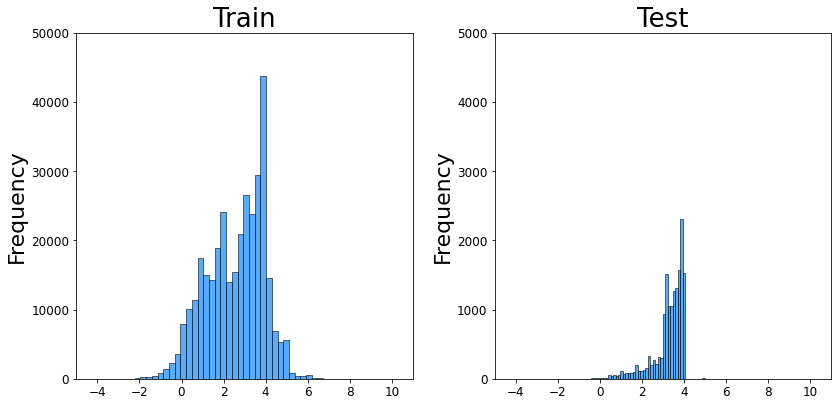

In [234]:
al = 0.2

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train', fontsize=26)
sns.histplot(train_df['Value'].tolist(), color="dodgerblue", bins=50)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 50000])

plt.subplot(1, 2, 2)
plt.title('Test', fontsize=26)
sns.histplot(test_df['Value'].tolist(), color="dodgerblue", bins=50)
plt.ylabel('Frequency', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([-5, 11])
plt.ylim([0, 5000])

plt.tight_layout(pad=2)
plt.show()

In [235]:
# train_df.to_csv("./kpro_data_train.csv", index=False)
# test_df.to_csv("./kpro_data_test.csv", index=False)